In [1]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
import torch.utils.data as data
from utils import *
from models import *
import numpy as np
import matplotlib.pyplot as plt

## Data Setup

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
]) 

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
])

dataloader = datasets.CIFAR10
batch_size = 64
test_bs = 256

trainset = dataloader(root='./data', train=True, download=True, transform=transform_train)
trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = dataloader(root='./data', train=False, download=True,
        transform=transform_test)
testloader = data.DataLoader(testset, batch_size=test_bs, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model Init

In [63]:
model = AlexNet(num_classes=10).to(device)

## Train

In [64]:
EPOCHS = 50
lr = 1e-3
optim = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()
lambda_TV = 1e-4
layer_mask = [0]

### Without TV:

In [4]:
def eval_model(model, testloader, criterion):
    model.eval()
    class_losses = []
    accs = []
    with torch.no_grad():
        for batch_input, batch_labels in testloader:
            batch_input = batch_input.to(device)
            batch_labels = batch_labels.to(device)
            
            batch_output = model(batch_input)
            batch_pred = torch.argmax(batch_output, dim = 1)
            acc = torch.mean(torch.eq(batch_pred,batch_labels).type(torch.float))
            class_loss = criterion(batch_output,batch_labels)
            
            accs.append(acc.item())
            class_losses.append(class_loss.item())
    return np.mean(accs),np.mean(class_losses)

In [15]:
def train_no_tv(model, optim, viz = False, **kwargs):
    print("Starting Without TV Training")
    val_losses = []
    val_accs = []
    losses = []
    TVs = []
    
    EPOCHS = kwargs['EPOCHS']
    criterion = kwargs['criterion']
    layer_mask = kwargs['layer_mask']
    
    for e in range(EPOCHS):
        # validation
        val_acc, val_loss = eval_model(model,testloader,criterion)
        print("Epoch", e, "| Test Acc:", "{:8.4f}".format(val_acc), "| Test Loss:", "{:8.4f}".format(val_loss), end = "")
        val_accs.append(val_acc)
        val_losses.append(val_losses)
        
        # visualize weights
        if viz:
            visualizeWeights(model, 'WithoutTV_Epoch' + str(e))
        
        # training
        model.train()
        class_losses = []
        TV_losses = []
        ok = 0
        with torch.no_grad():
            init = TVLossMat(model, layer_mask).item()
        for batch_input, batch_labels in trainloader:
            optim.zero_grad()
            batch_input = batch_input.to(device)
            batch_labels = batch_labels.to(device)
            batch_output = model(batch_input)

            class_loss = criterion(batch_output,batch_labels)
            loss = class_loss
            loss.backward()
            optim.step()

            class_losses.append(class_loss.item())
        print(" | Train loss:", "{:8.4f}".format(np.mean(class_losses)), "| Init TV:", "{:8.4f}".format(init))
        losses.append(np.mean(class_losses))
        TVs.append(init)
    return val_accs, val_losses,losses,TVs

### With TV

In [16]:
def train_tv(model,optim,viz=False,**kwargs):
    
    EPOCHS = kwargs['EPOCHS']
    criterion = kwargs['criterion']
    layer_mask = kwargs['layer_mask']
    lambda_TV = kwargs['lambda_TV']
    
    print("Starting TV Training")
    val_losses = []
    val_accs = []
    losses = []
    TVs = []
    for e in range(EPOCHS):
        # validation
        val_acc, val_loss = eval_model(model,testloader,criterion)
        print("Epoch", e, "| Test Acc:", "{:8.4f}".format(val_acc), "| Test Loss:", "{:8.4f}".format(val_loss), end = "")
        val_accs.append(val_acc)
        val_losses.append(val_losses)
        
         # visualize weights
        if viz:
            visualizeWeights(model, 'WithTV_Epoch' + str(e))
        
        # training
        model.train()
        class_losses = []
        TV_losses = []
        with torch.no_grad():
            init = TVLossMat(model, layer_mask).item()
        for batch_input, batch_labels in trainloader:
            optim.zero_grad()
            batch_input = batch_input.to(device)
            batch_labels = batch_labels.to(device)
            batch_output = model(batch_input)

            class_loss = criterion(batch_output,batch_labels)
            TV_loss = TVLossMat(model, layer_mask)
            loss = class_loss + lambda_TV*TV_loss
            loss.backward()
            optim.step()

            class_losses.append(class_loss.item())
            TV_losses.append(TV_loss.item()*lambda_TV)

        print(" | Train loss:", "{:8.4f}".format(np.mean(class_losses)), "| Init TV:", "{:8.4f}".format(init), "| TV loss:", "{:8.4f}".format(np.mean(TV_losses)))
        losses.append(np.mean(class_losses))
        TVs.append(init)
        
    return val_accs, val_losses,losses,TVs

### Visualize Weights

In [17]:
def visualizeWeights(model, folder, title):
    params_c = list(list(model.features.children())[0].parameters())[0].detach().cpu().numpy()
    params_c = np.moveaxis(params_c,1,-1)
    params_c = (params_c - params_c.min())/(params_c.max() - params_c.min())
    
    fig = plt.figure(figsize=(24, 24))
    for i in range(1,65):
        plt.subplot(11,11,i)
        weights = params_c[i-1,:,:,:]
        plt.imshow(weights)
    plt.title(title)
    plt.savefig('./filters/' + title+'.png')

## Experiment 1: First Layer

In [4]:
def compare(n_trials, layer_mask = [0]):
    without_res = {}
    with_res = {}
    EPOCHS = 25
    lr = 1e-3
    criterion = nn.CrossEntropyLoss()
    lambda_TV = 1e-4
    kwargs = {
        'criterion': criterion,
        'lambda_TV': lambda_TV,
        'layer_mask': layer_mask,
        'EPOCHS': EPOCHS
    }
    for i in range(n_trials):
        if i == n_trials - 1:
            viz = True
        else:
            viz = False
        # without TV
        model = AlexNet(num_classes=10).to(device)
        torch.save(model.state_dict(),'default.pt')
        optim = torch.optim.Adam(model.parameters(), lr = lr)
        without_res[i] = {}
        without_v_acc, without_v_loss, without_loss, without_tv = train_no_tv(model,optim,viz=viz,**kwargs)
        without_res[i]['losses'] = without_loss
        without_res[i]['tv'] = without_tv
        without_res[i]['val_losses'] = without_v_loss
        without_res[i]['val_accs'] = without_v_acc
        
        # with TV
        model = AlexNet(num_classes=10).to(device)
        model.load_state_dict(torch.load('default.pt'))
        optim = torch.optim.Adam(model.parameters(), lr = lr)
        with_res[i] = {}
        with_v_acc, with_v_loss, with_loss, with_tv = train_tv(model,optim,viz=viz,**kwargs)
        with_res[i]['losses'] = with_loss
        with_res[i]['tv'] = with_tv
        with_res[i]['val_losses'] = with_v_loss
        with_res[i]['val_accs'] = with_v_acc
    return without_res, with_res
        

Starting Without TV Training
Epoch 0 | Test Acc:   0.0991 | Test Loss:   2.3027 | Train loss:   1.8056 | Init TV: 1043.5265
Epoch 1 | Test Acc:   0.3655 | Test Loss:   1.6152 | Train loss:   1.5189 | Init TV: 1095.9279
Epoch 2 | Test Acc:   0.4813 | Test Loss:   1.4134 | Train loss:   1.3773 | Init TV: 1158.9868
Epoch 3 | Test Acc:   0.5188 | Test Loss:   1.3317 | Train loss:   1.2955 | Init TV: 1227.4464
Epoch 4 | Test Acc:   0.5560 | Test Loss:   1.2423 | Train loss:   1.2322 | Init TV: 1294.4207
Epoch 5 | Test Acc:   0.5814 | Test Loss:   1.1784 | Train loss:   1.1771 | Init TV: 1364.6898
Epoch 6 | Test Acc:   0.5869 | Test Loss:   1.1826 | Train loss:   1.1345 | Init TV: 1427.2596
Epoch 7 | Test Acc:   0.6044 | Test Loss:   1.1288 | Train loss:   1.1032 | Init TV: 1491.2184
Epoch 8 | Test Acc:   0.5944 | Test Loss:   1.1455 | Train loss:   1.0729 | Init TV: 1552.1506
Epoch 9 | Test Acc:   0.6145 | Test Loss:   1.0946 | Train loss:   1.0408 | Init TV: 1613.8197
Epoch 10 | Test Acc: 

Epoch 4 | Test Acc:   0.5388 | Test Loss:   1.3052 | Train loss:   1.2943 | Init TV: 370.8666 | TV loss:   0.0384
Epoch 5 | Test Acc:   0.5558 | Test Loss:   1.2438 | Train loss:   1.2464 | Init TV: 396.8680 | TV loss:   0.0411
Epoch 6 | Test Acc:   0.5370 | Test Loss:   1.2798 | Train loss:   1.2065 | Init TV: 425.2615 | TV loss:   0.0437
Epoch 7 | Test Acc:   0.5825 | Test Loss:   1.1830 | Train loss:   1.1657 | Init TV: 448.2199 | TV loss:   0.0460
Epoch 8 | Test Acc:   0.6028 | Test Loss:   1.1571 | Train loss:   1.1378 | Init TV: 471.0159 | TV loss:   0.0484
Epoch 9 | Test Acc:   0.5969 | Test Loss:   1.1538 | Train loss:   1.1247 | Init TV: 491.6477 | TV loss:   0.0500
Epoch 10 | Test Acc:   0.6106 | Test Loss:   1.1057 | Train loss:   1.1006 | Init TV: 505.4435 | TV loss:   0.0514
Epoch 11 | Test Acc:   0.6084 | Test Loss:   1.1295 | Train loss:   1.0828 | Init TV: 525.3110 | TV loss:   0.0533
Epoch 12 | Test Acc:   0.6177 | Test Loss:   1.0994 | Train loss:   1.0545 | Init TV: 

/home/kurtis/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 | Train loss:   0.9765 | Init TV: 2169.0386
Epoch 21 | Test Acc:   0.6519 | Test Loss:   1.0388 | Train loss:   0.9661 | Init TV: 2213.8845
Epoch 22 | Test Acc:   0.6436 | Test Loss:   1.0596 | Train loss:   0.9581 | Init TV: 2261.3435
Epoch 23 | Test Acc:   0.6398 | Test Loss:   1.0647 | Train loss:   0.9468 | Init TV: 2304.0017
Epoch 24 | Test Acc:   0.6514 | Test Loss:   1.0118 | Train loss:   0.9433 | Init TV: 2346.7878
Starting TV Training
Epoch 0 | Test Acc:   0.0977 | Test Loss:   2.3027 | Train loss:   1.8784 | Init TV: 1041.3188 | TV loss:   0.0311
Epoch 1 | Test Acc:   0.3612 | Test Loss:   1.6644 | Train loss:   1.5931 | Init TV: 262.0087 | TV loss:   0.0284
Epoch 2 | Test Acc:   0.4588 | Test Loss:   1.5071 | Train loss:   1.4480 | Init TV: 311.5108 | TV loss:   0.0329
Epoch 3 | Test Acc:   0.4924 | Test Loss:   1.4003 | Train loss:   1.3614 | Init TV: 349.3608 | TV loss:   0.0372
Epoch 4 | Test Acc:   0.5382 | Test Loss:   1.2846 | Train loss:   1.3054 | Init TV: 386.7194

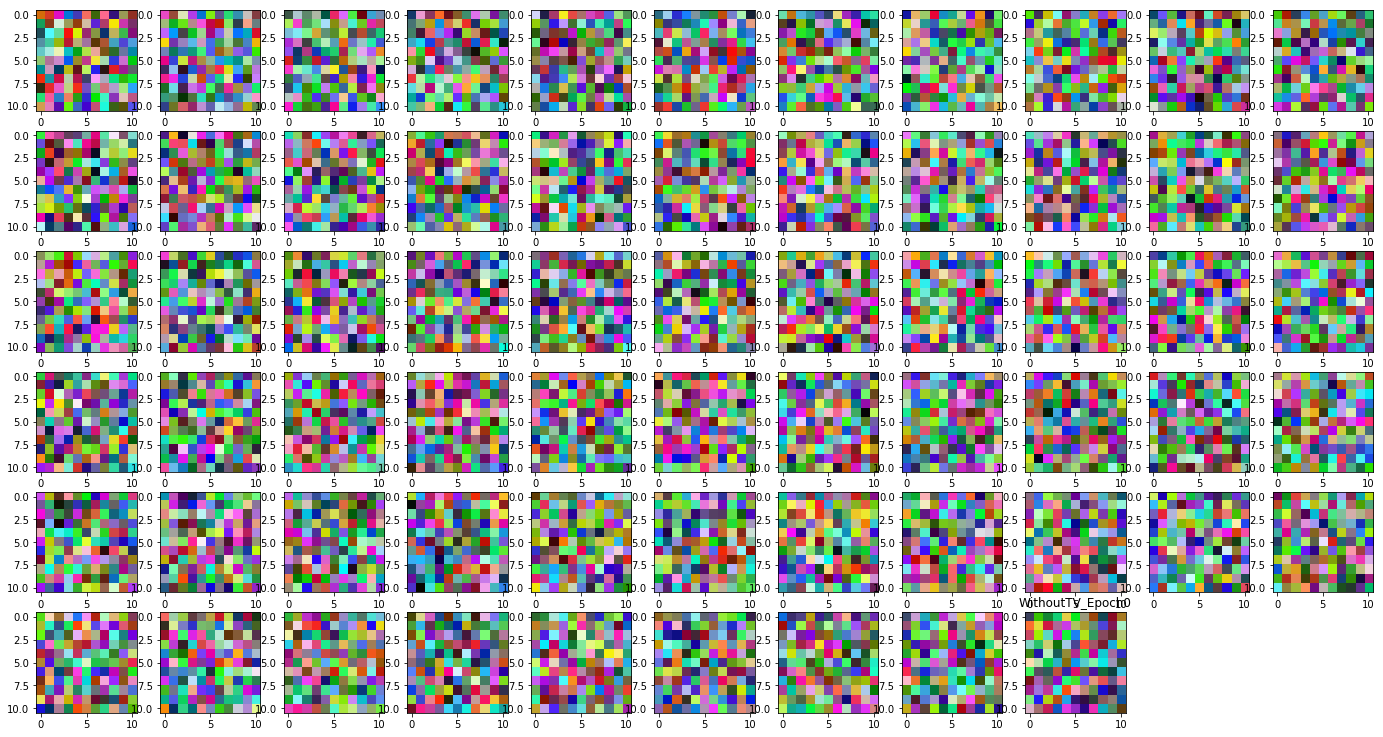

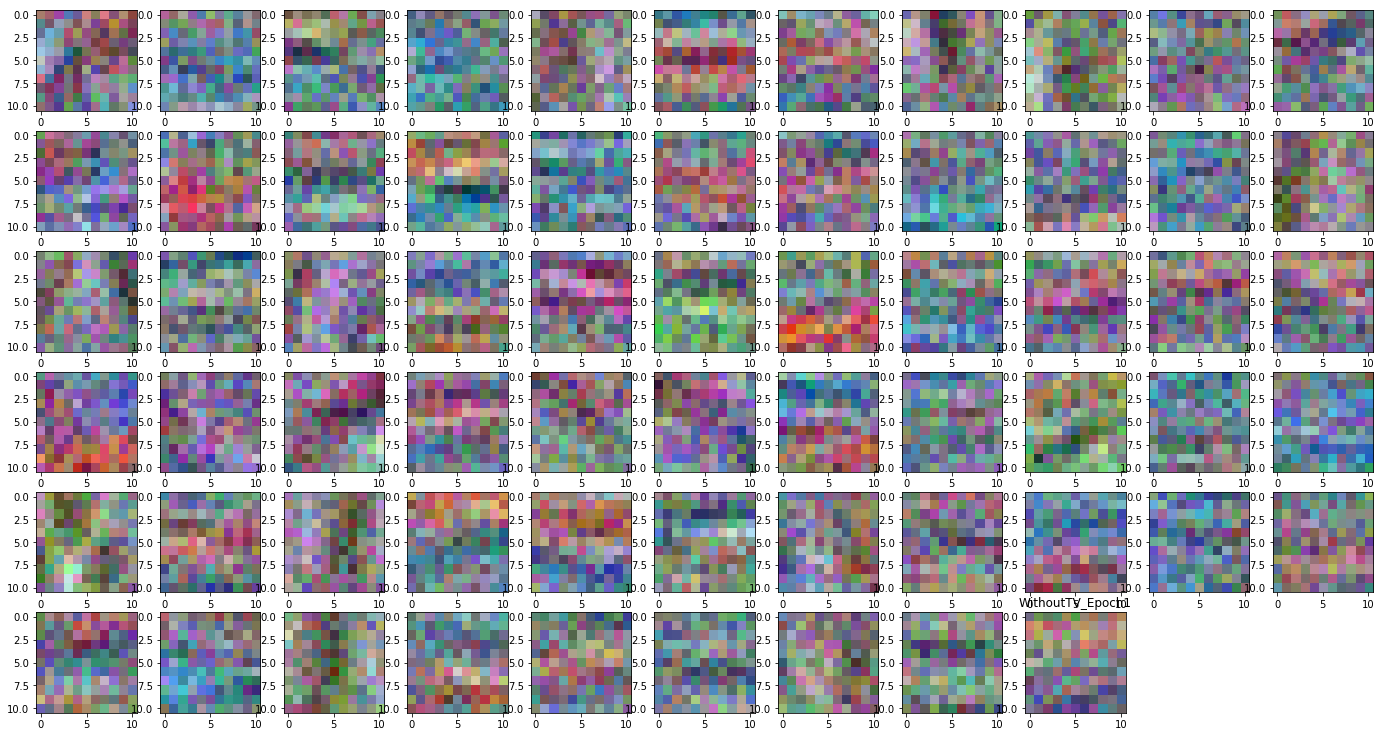

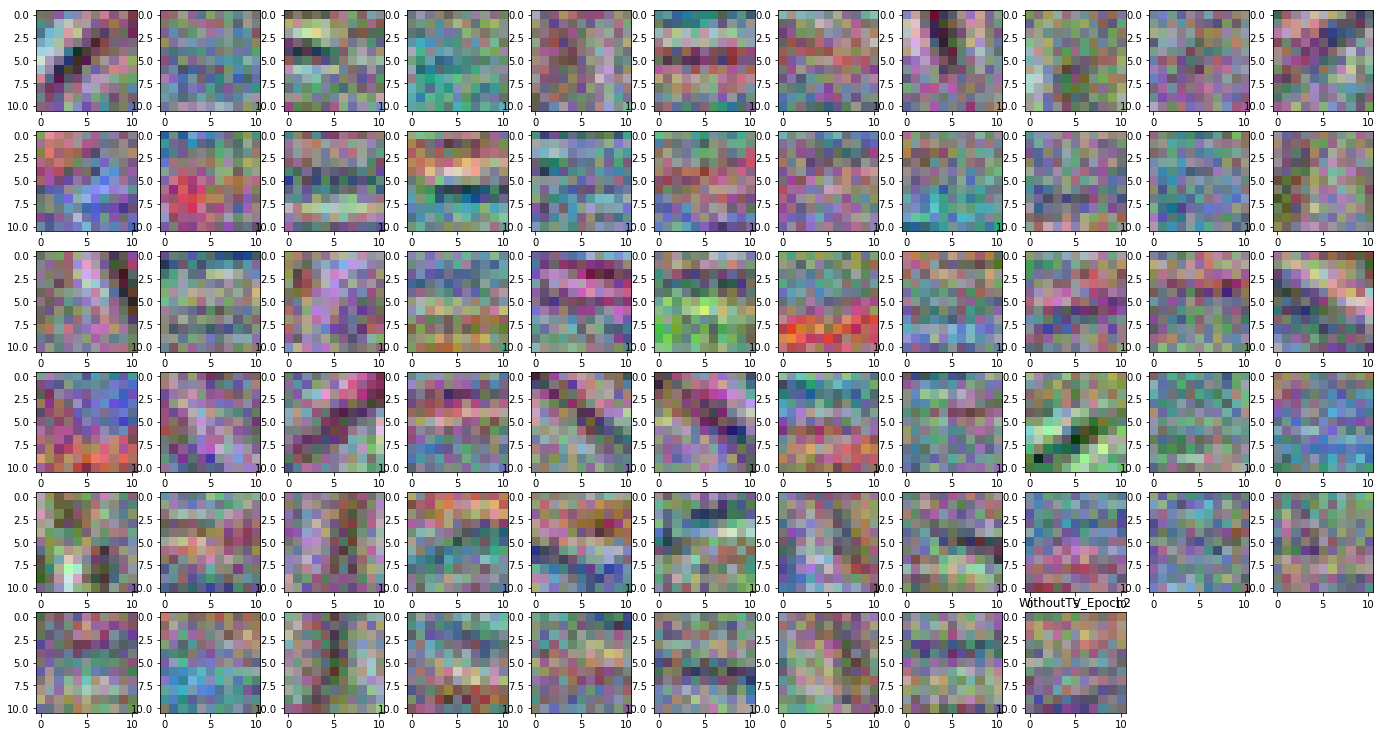

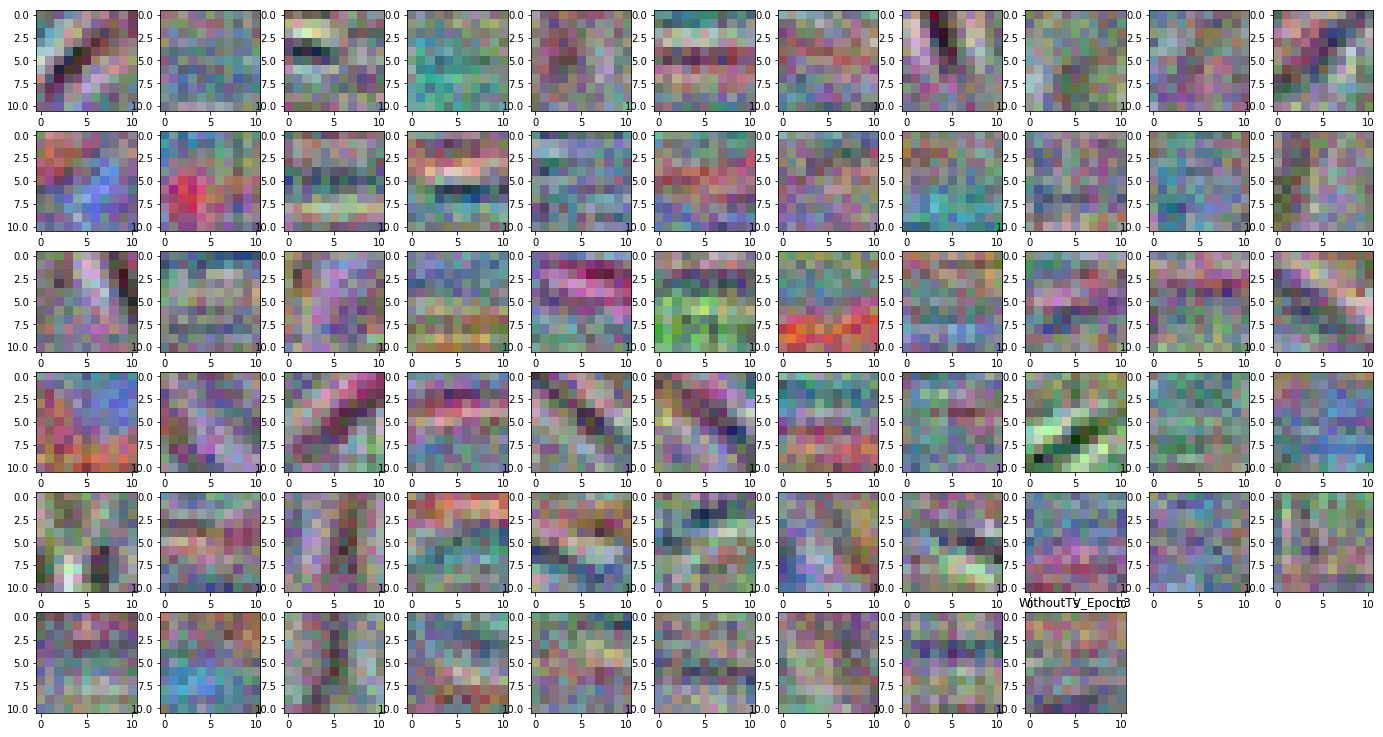

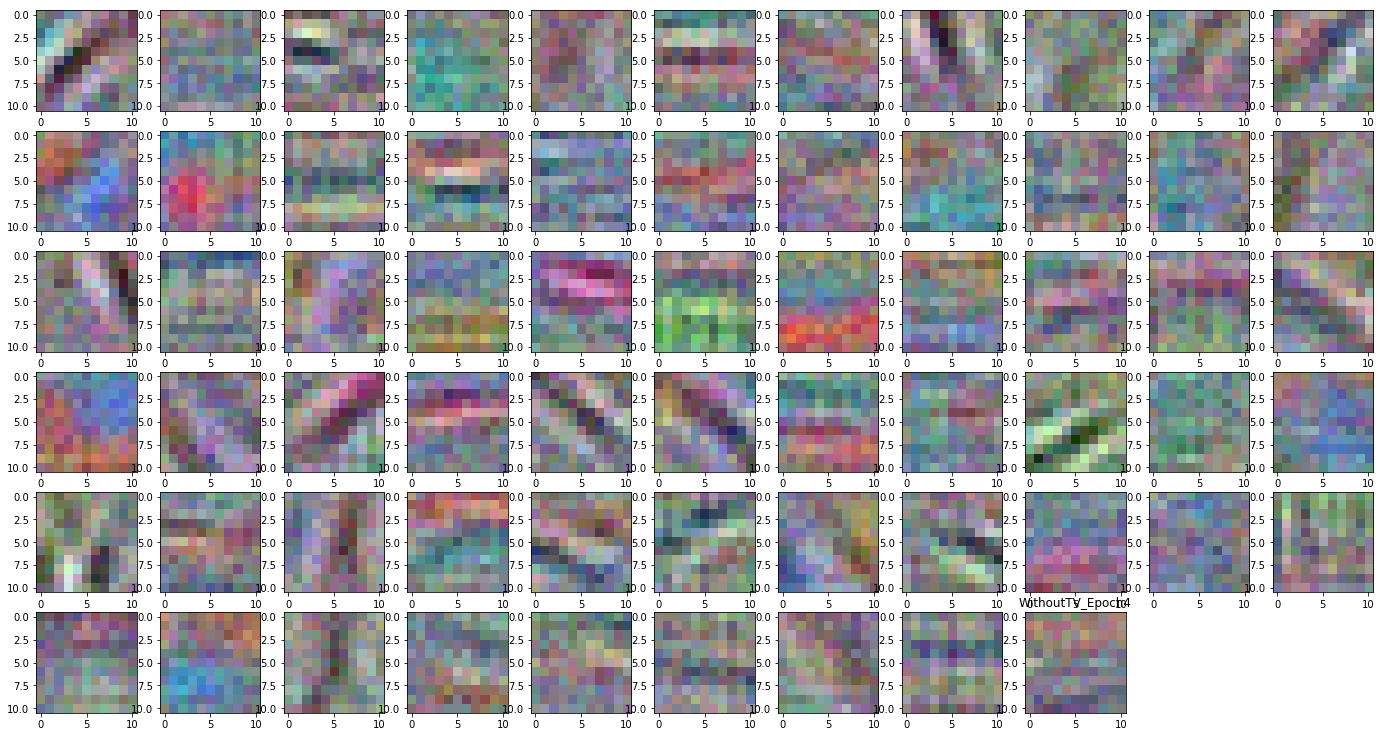

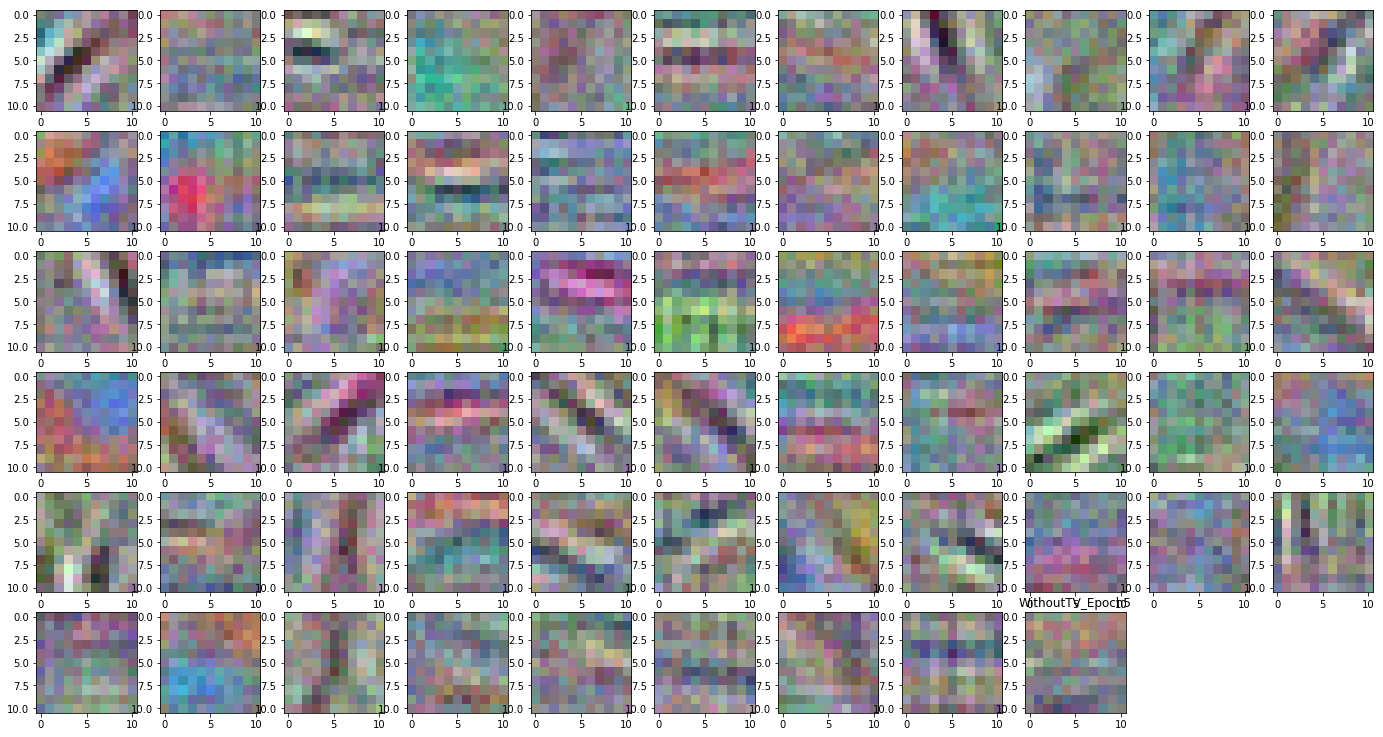

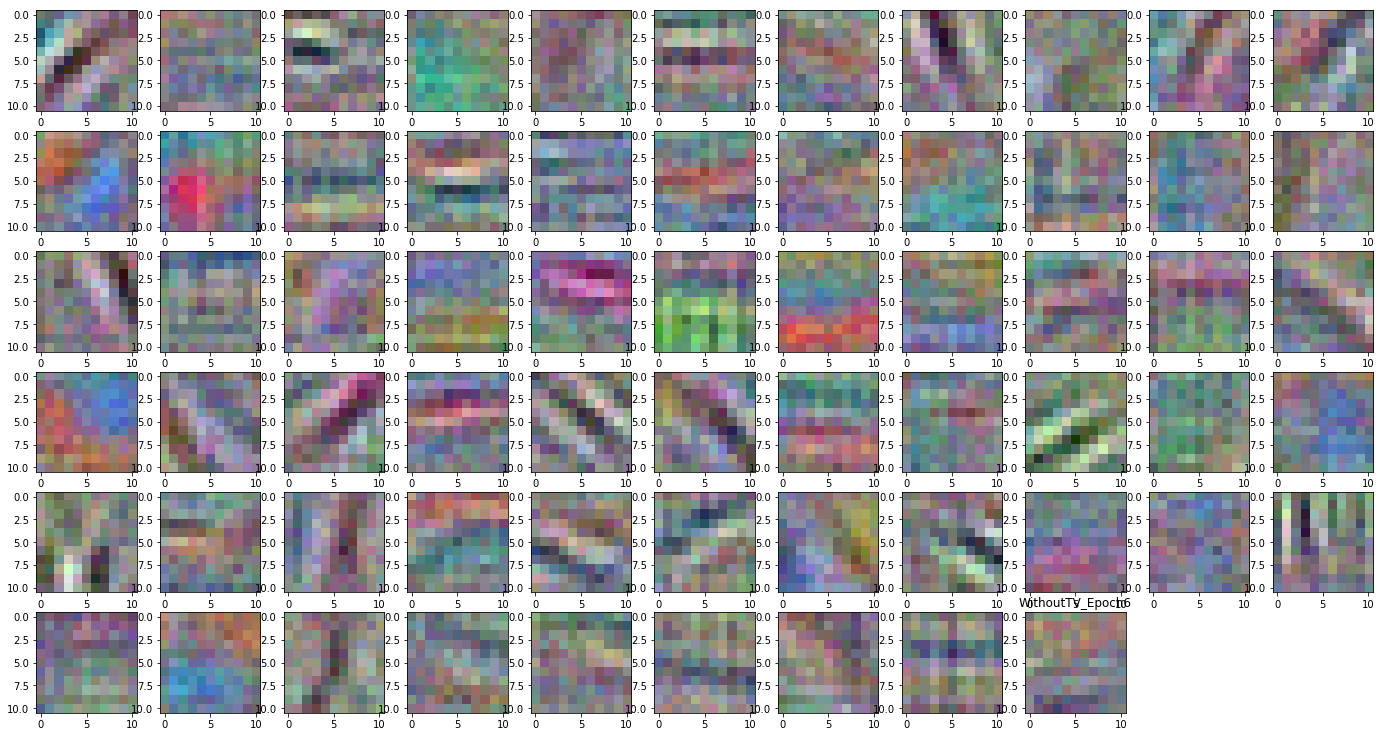

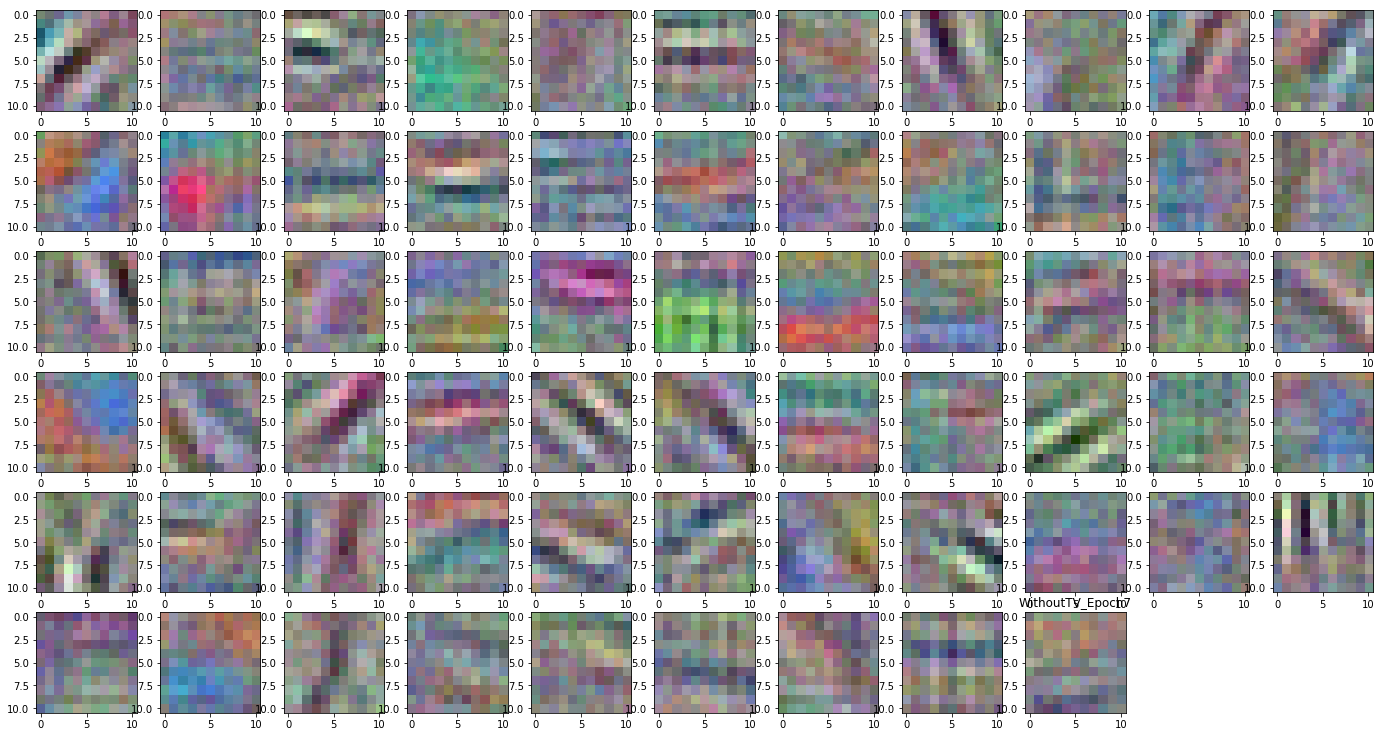

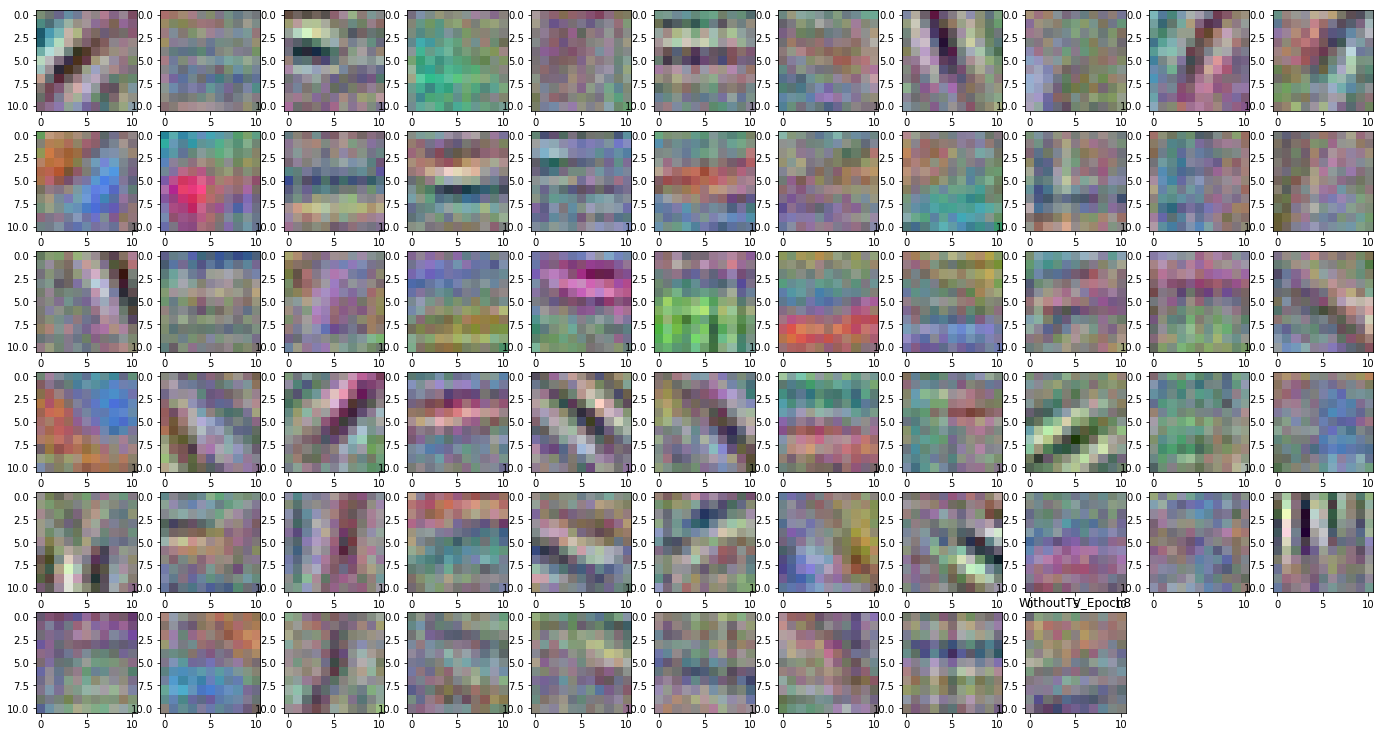

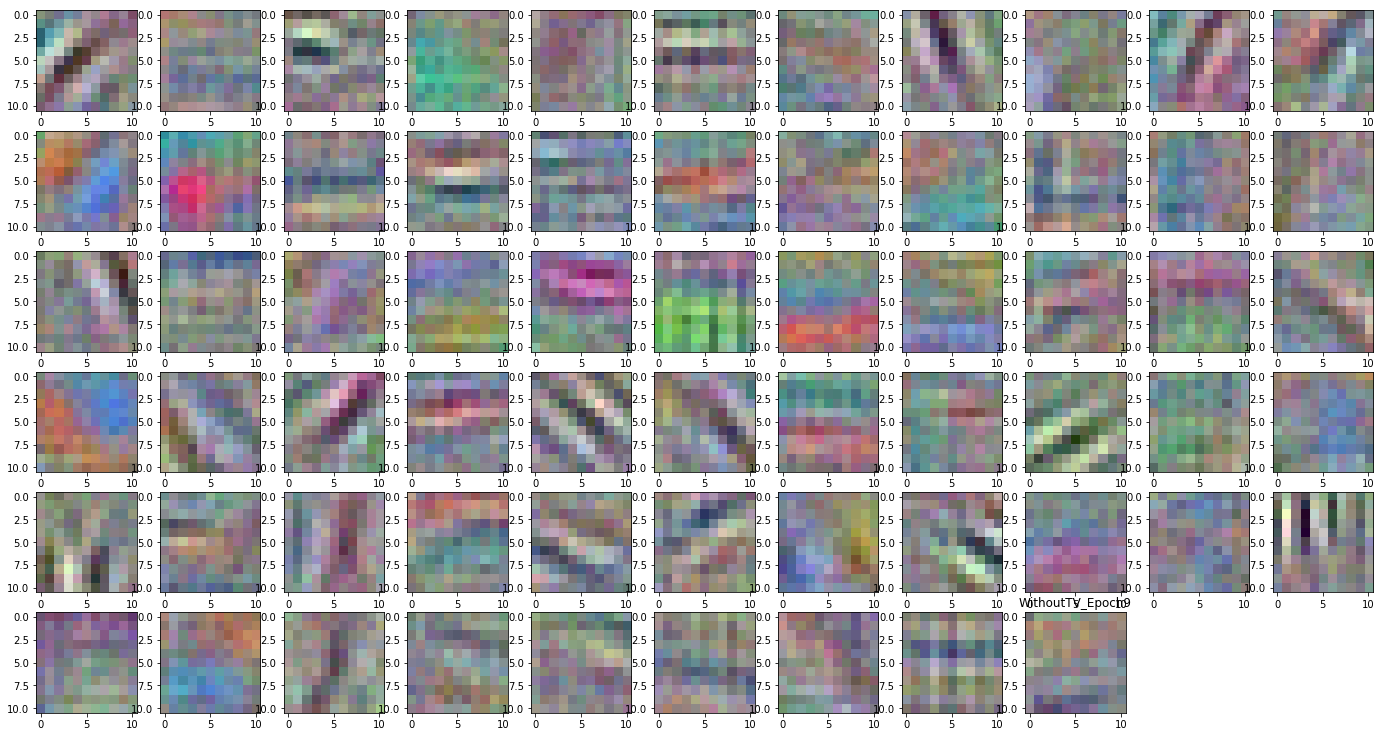

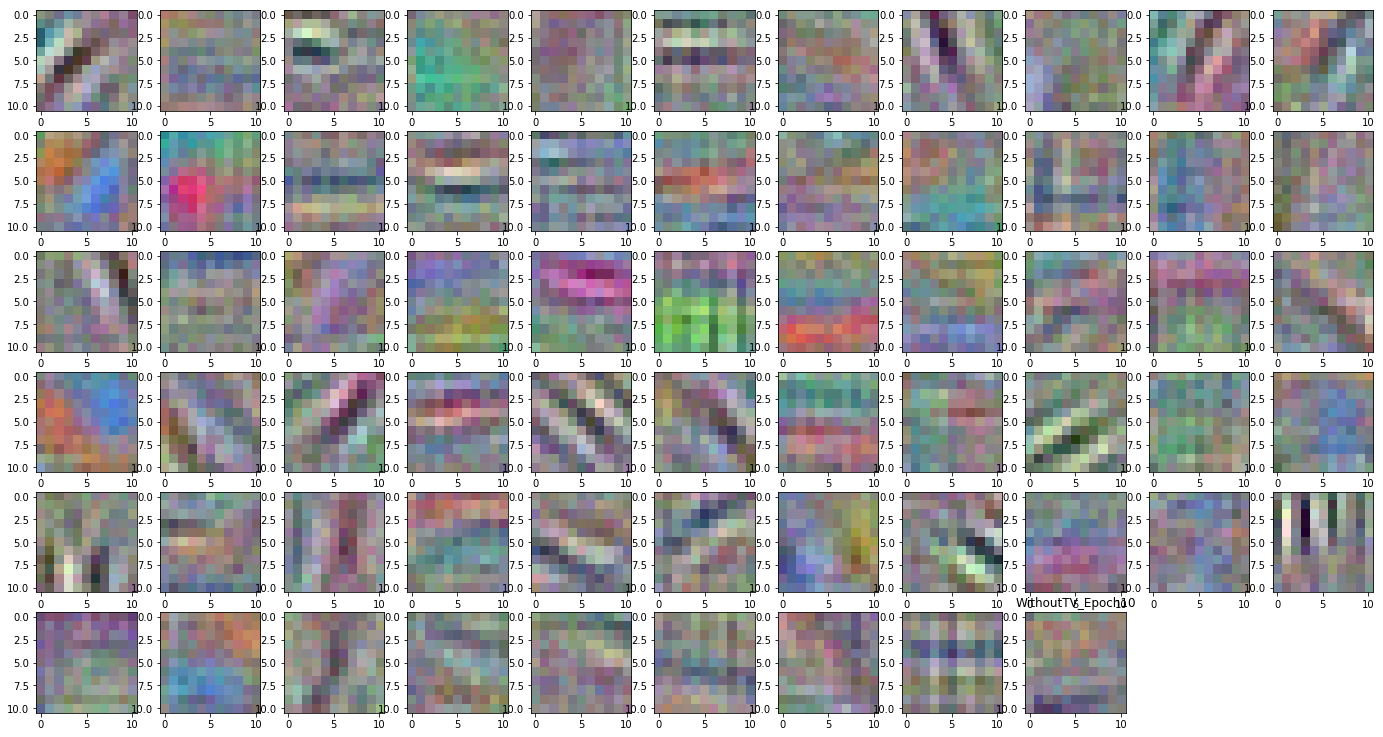

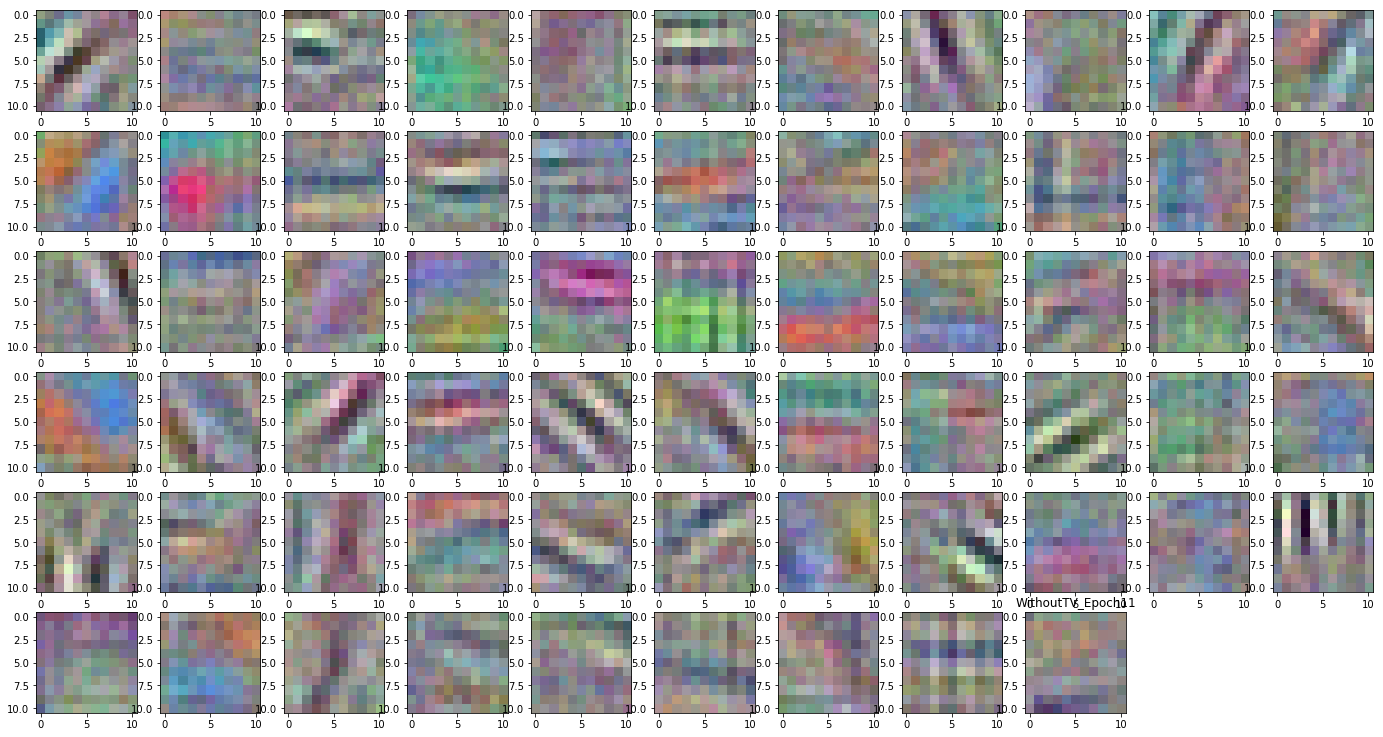

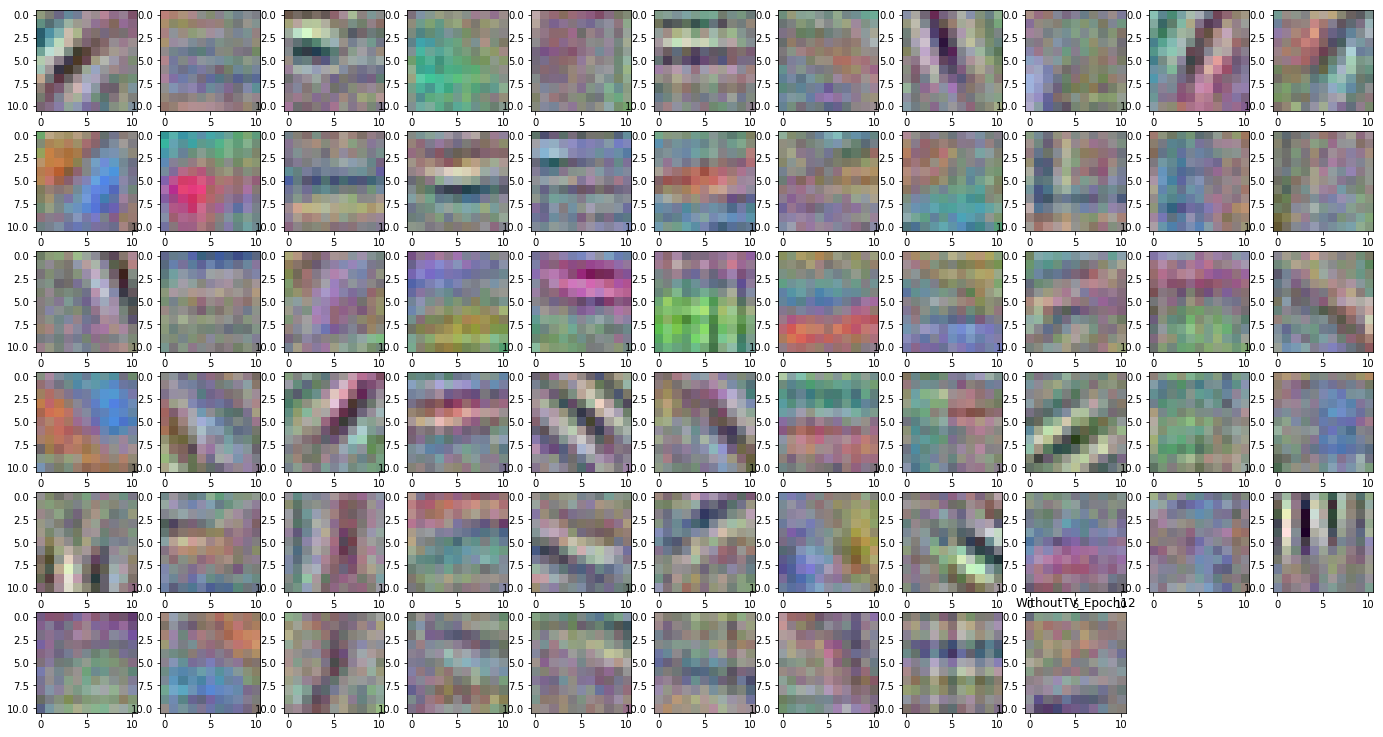

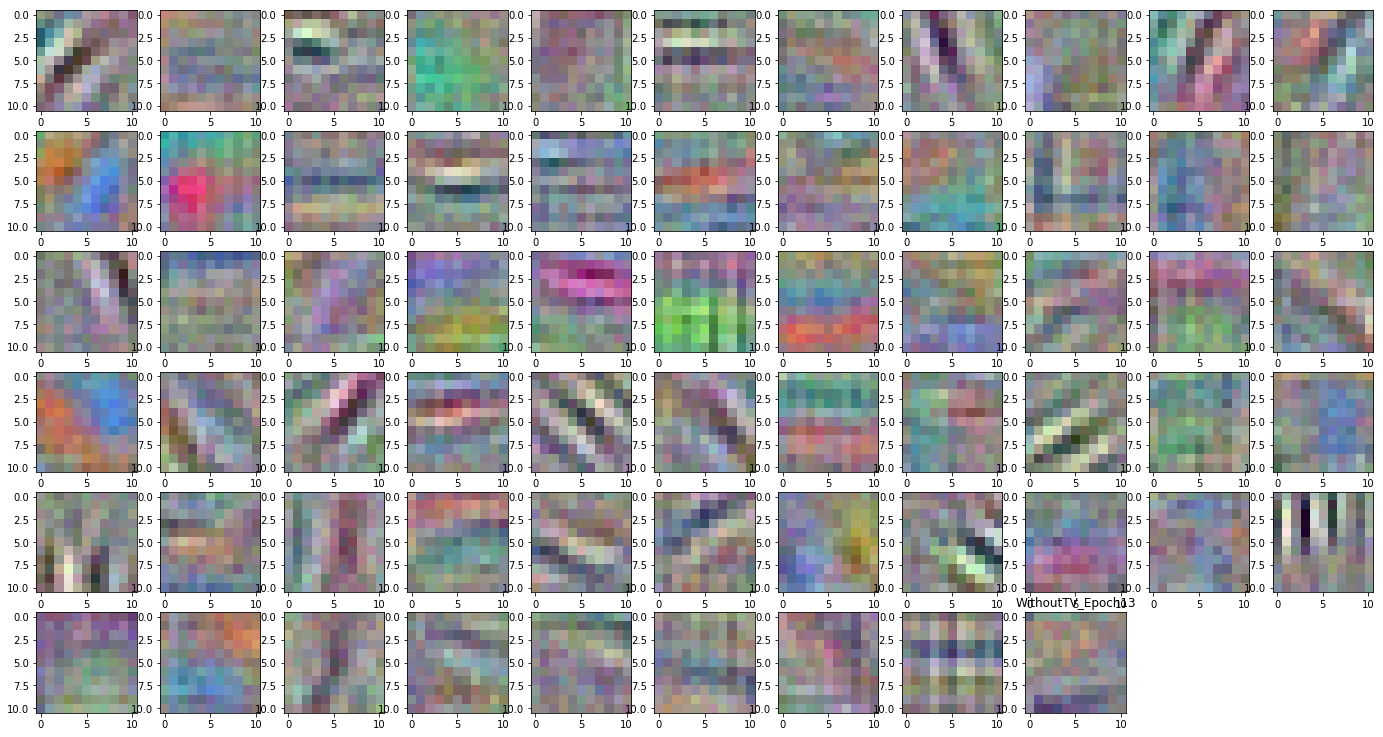

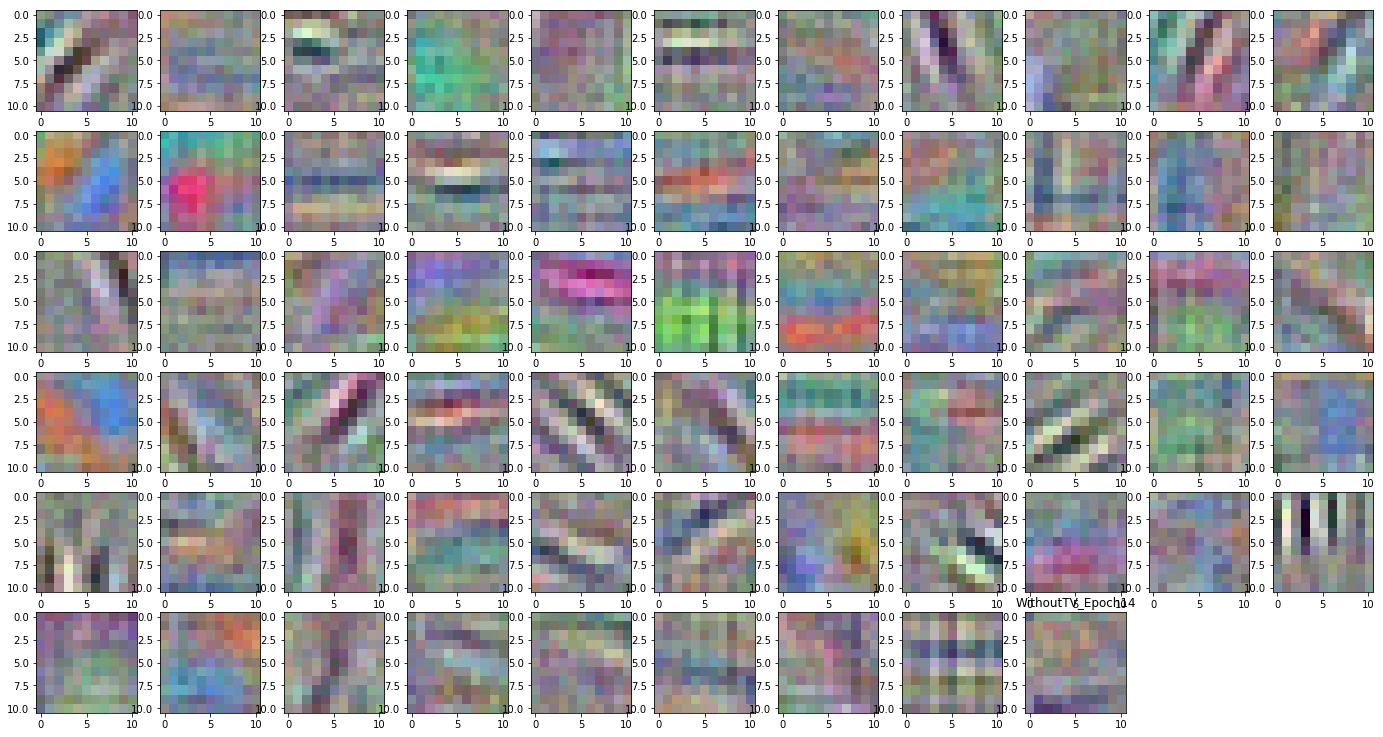

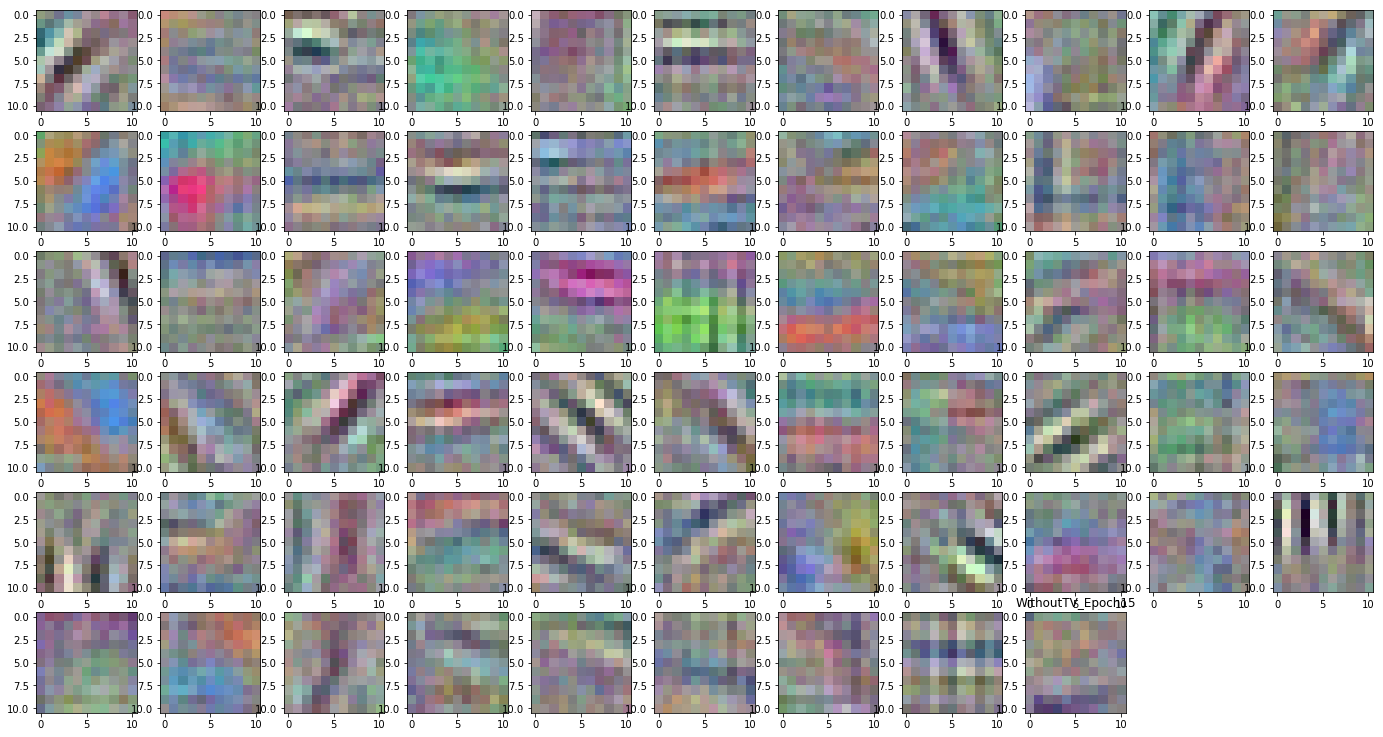

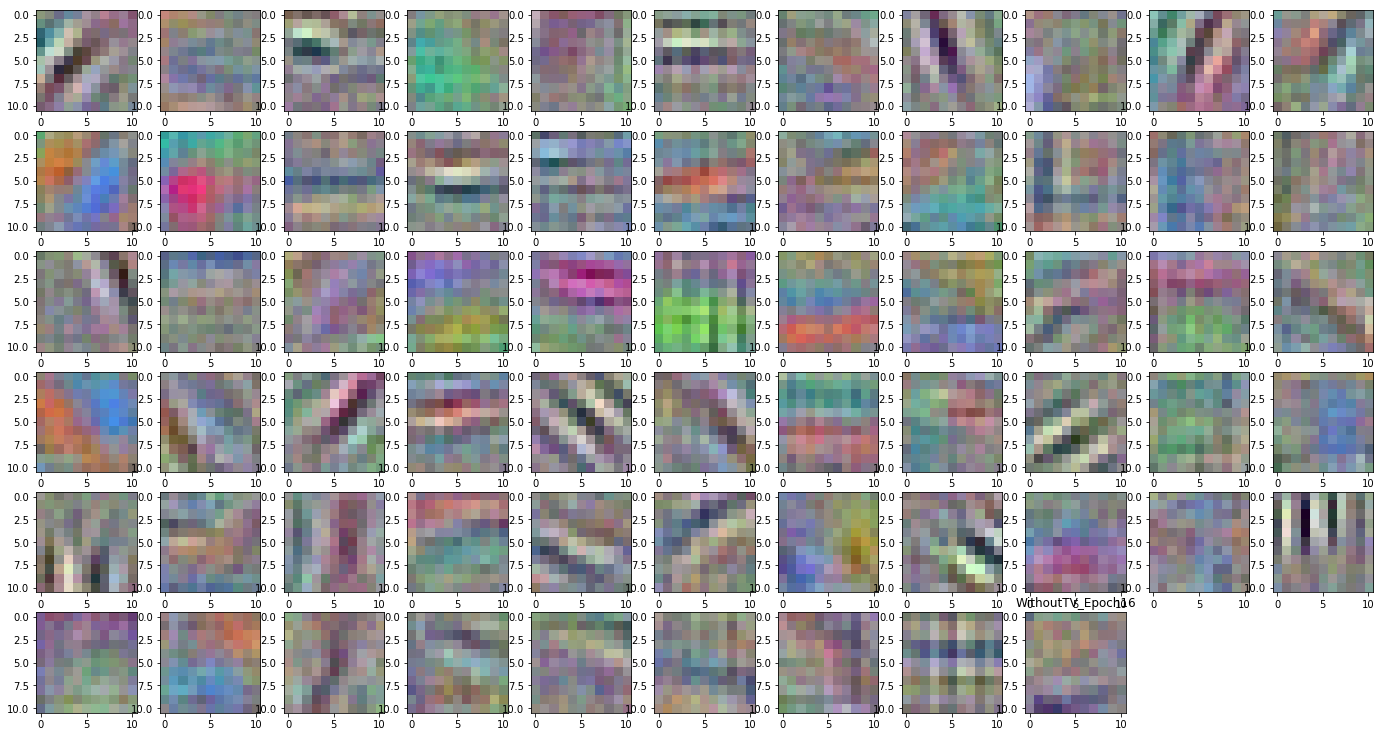

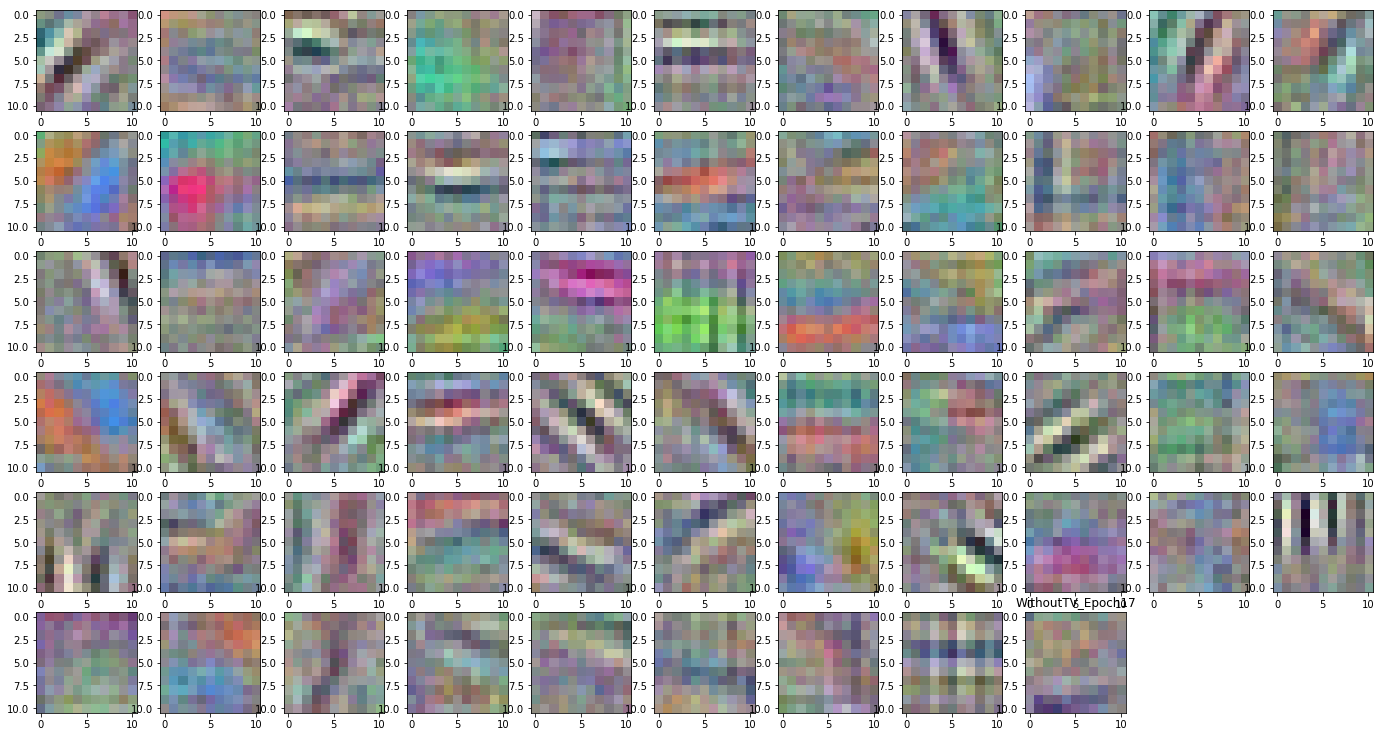

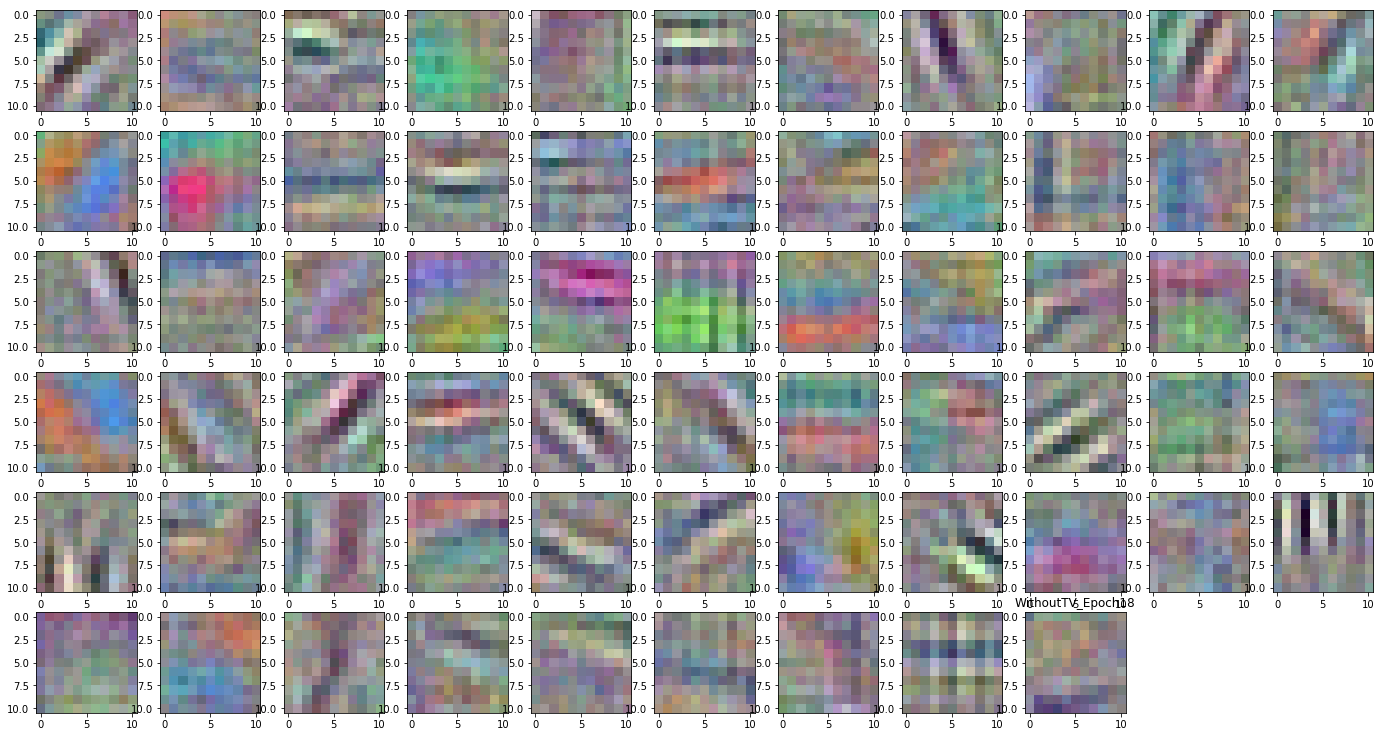

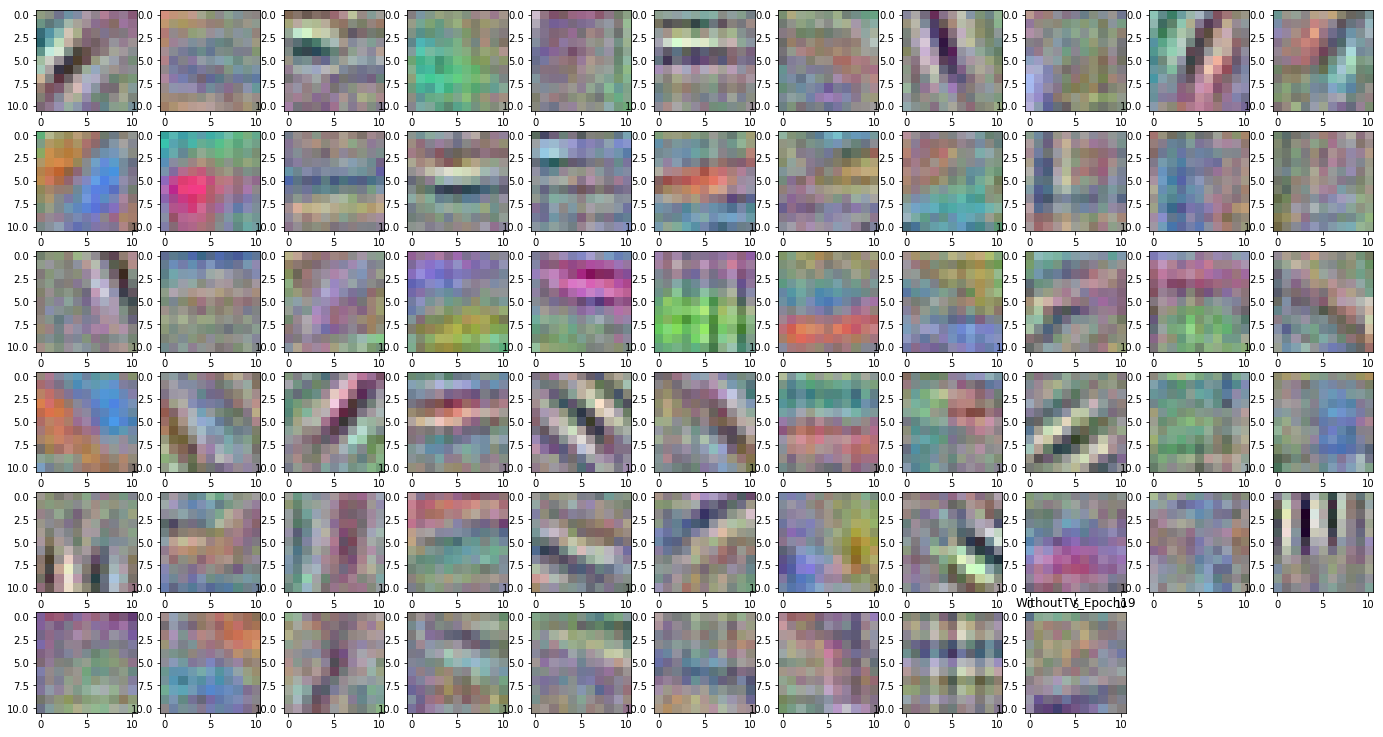

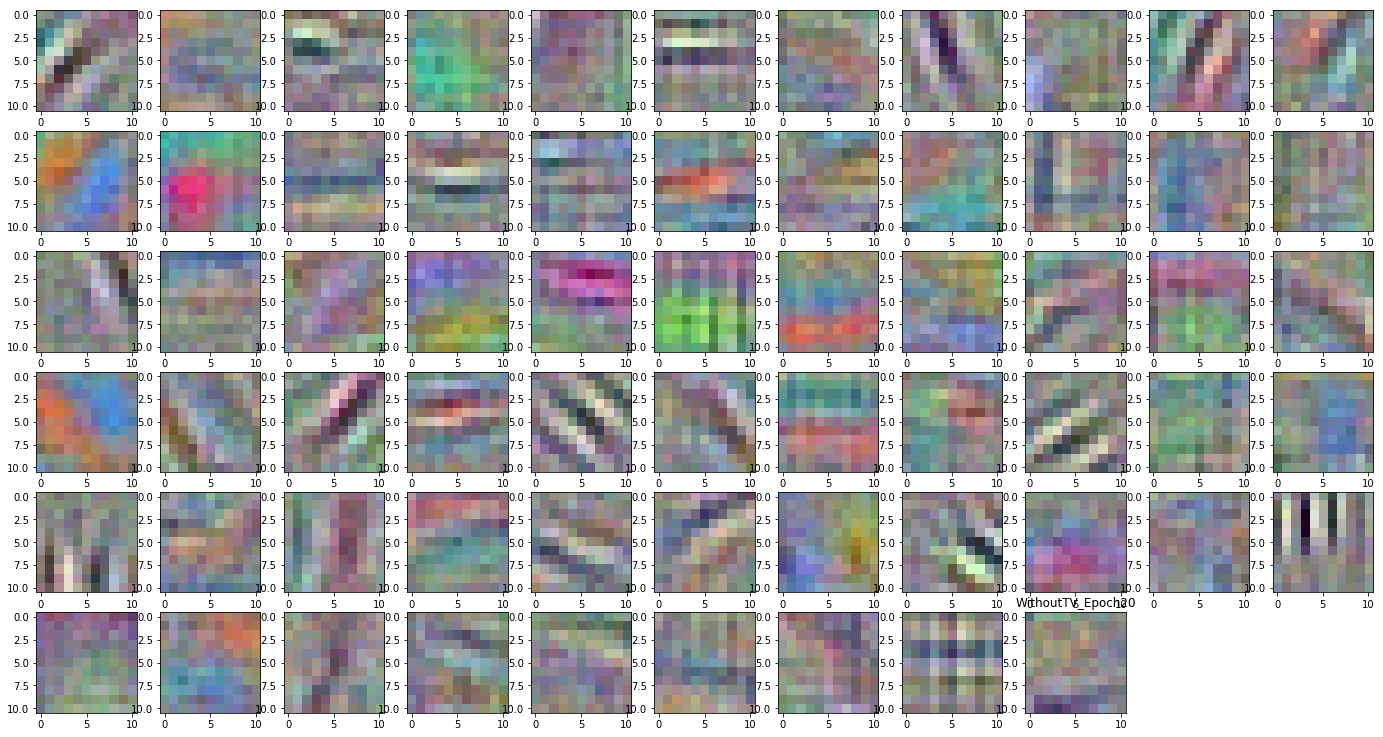

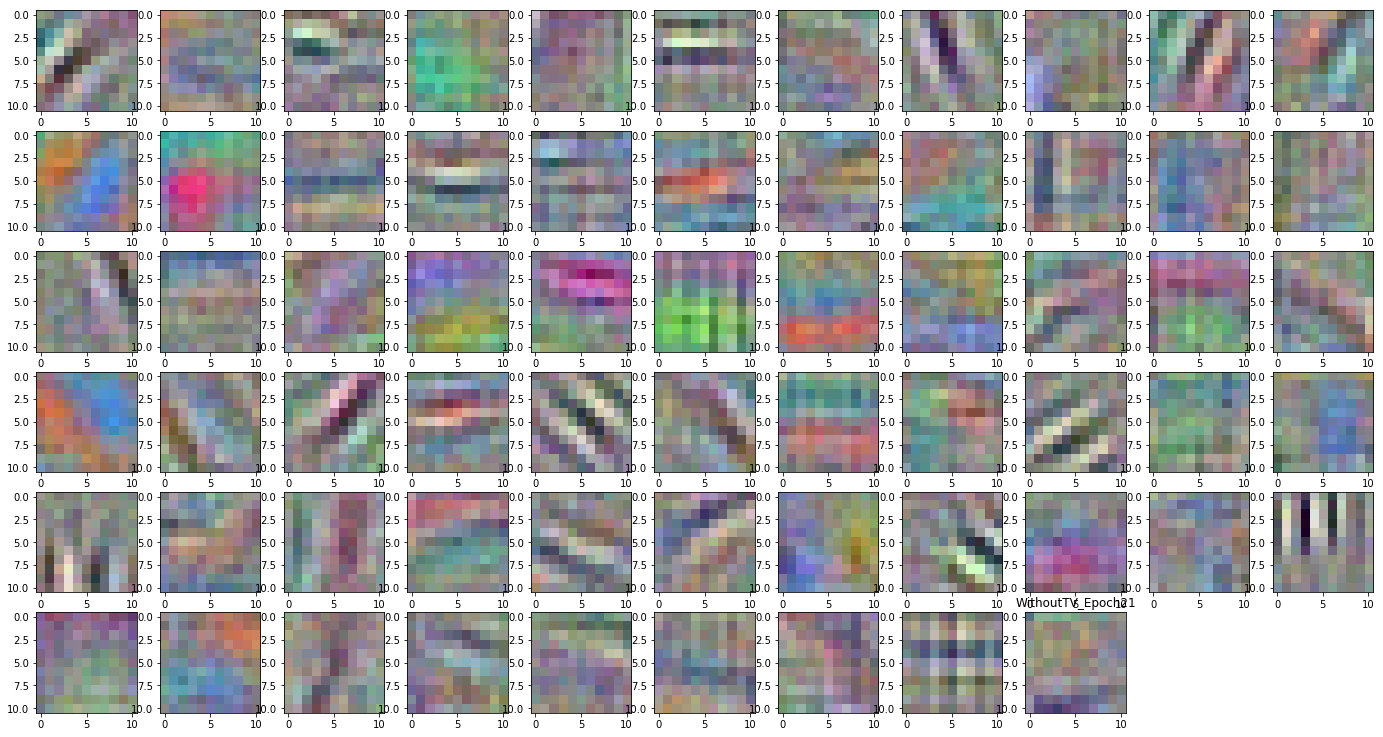

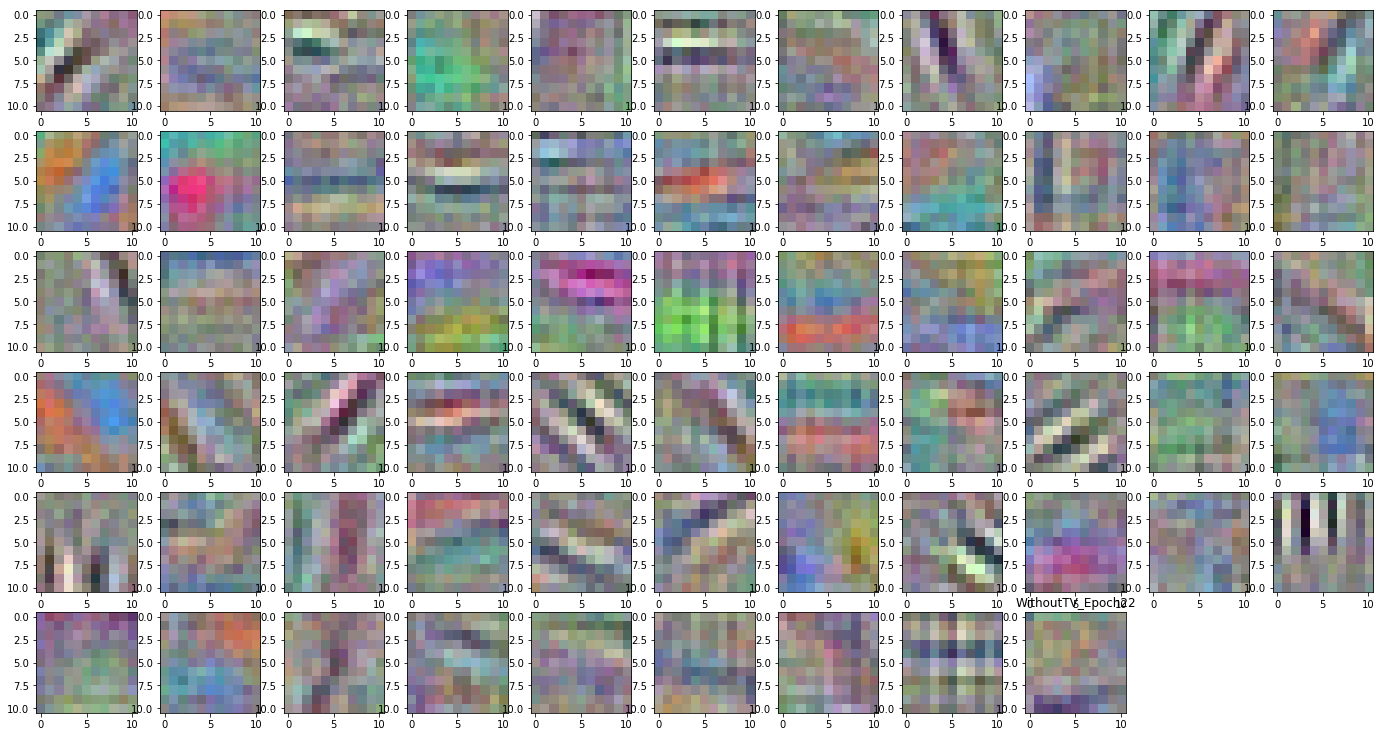

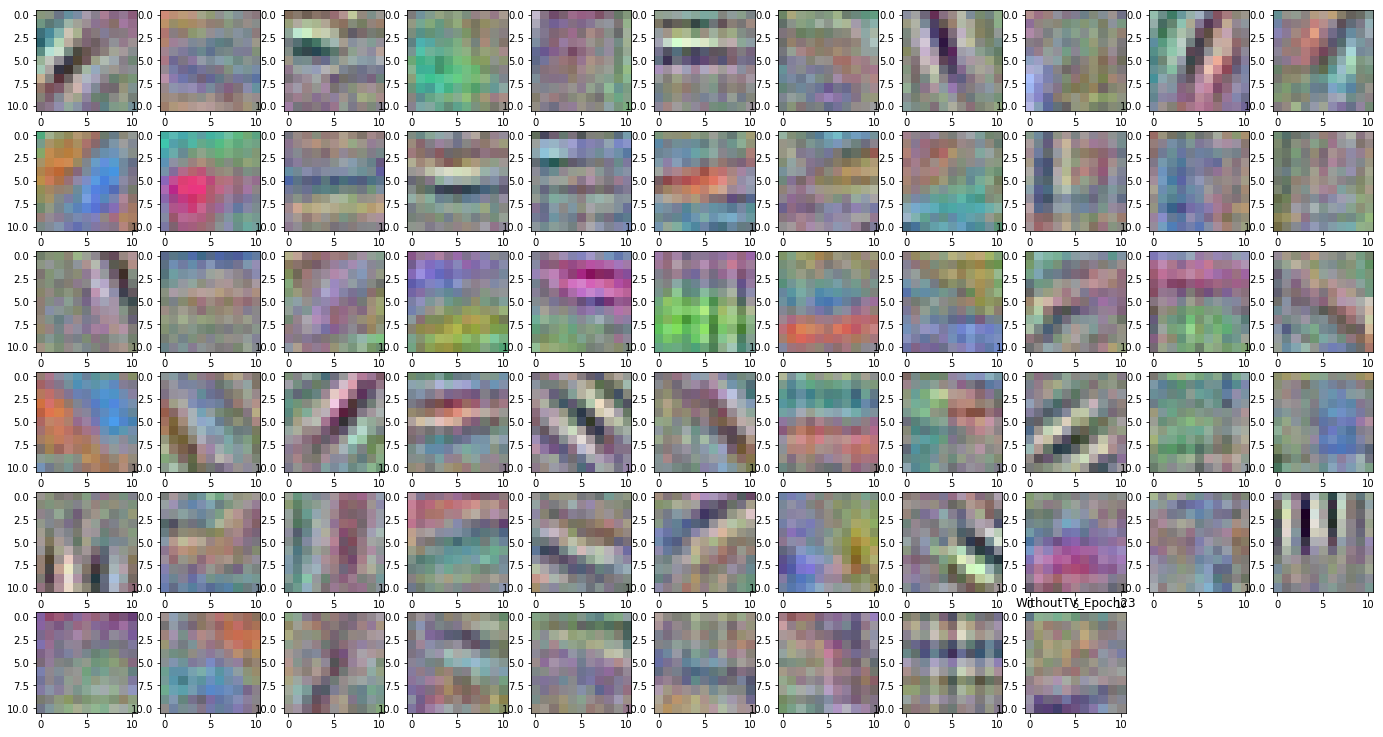

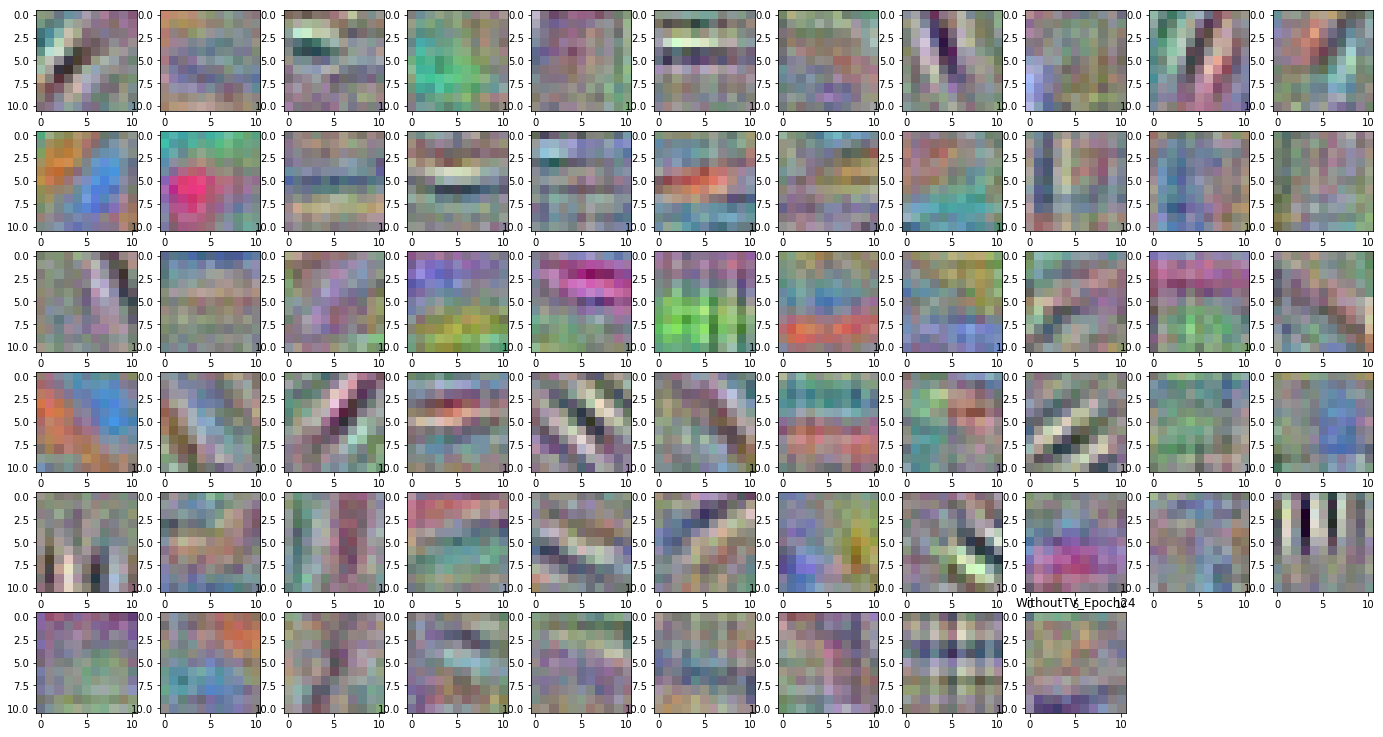

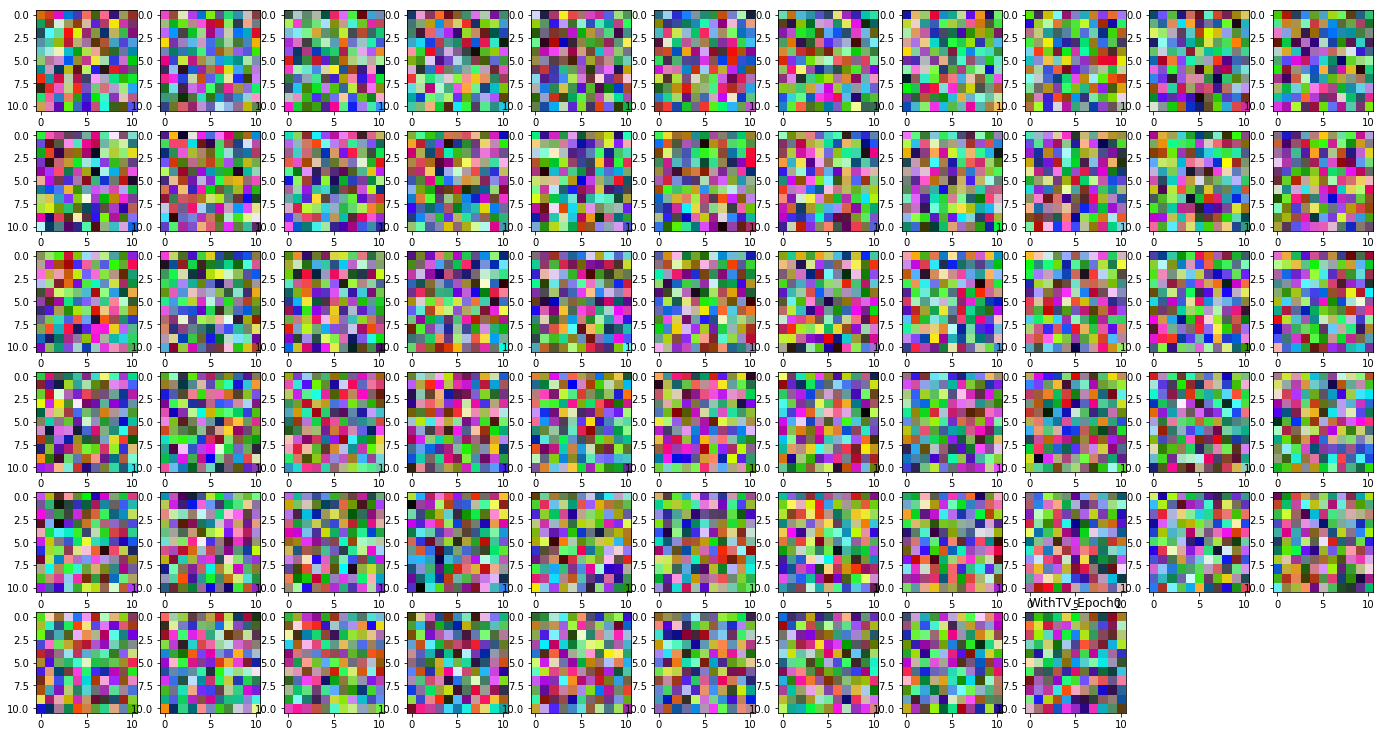

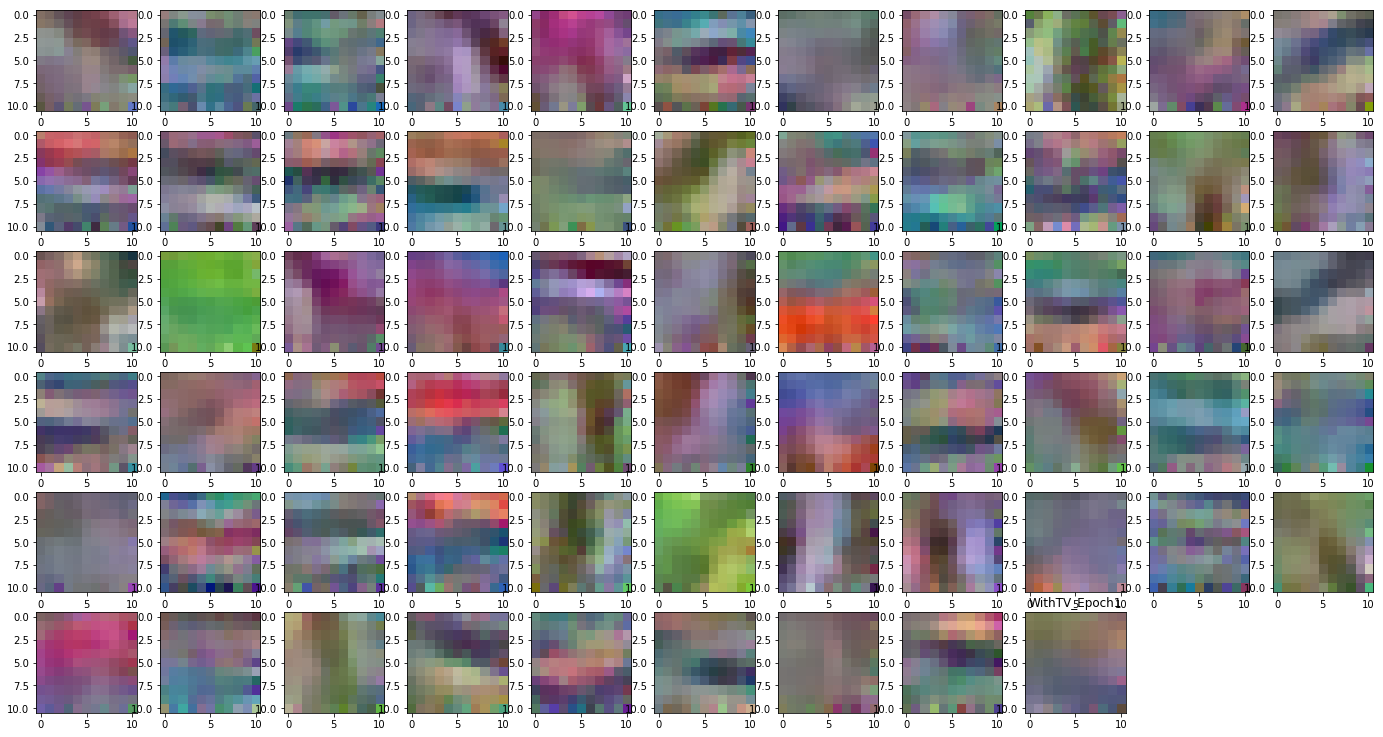

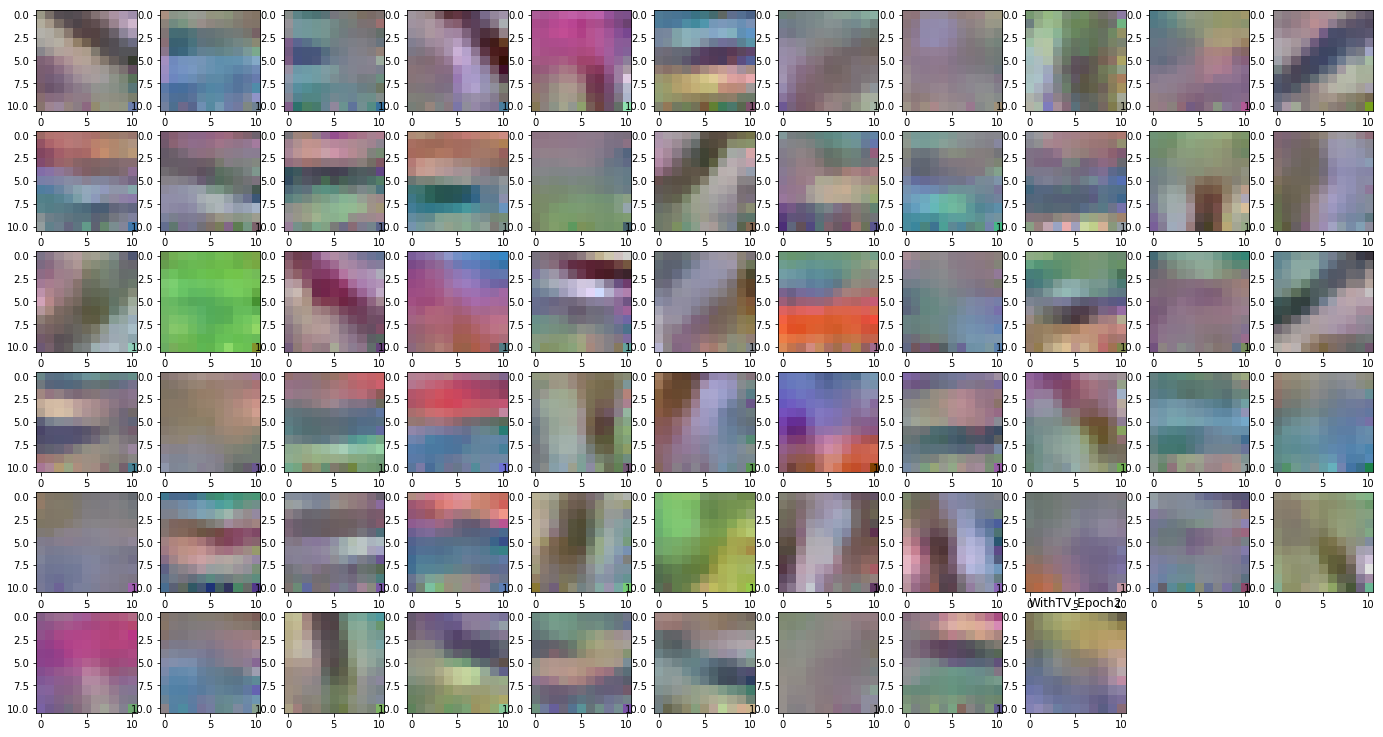

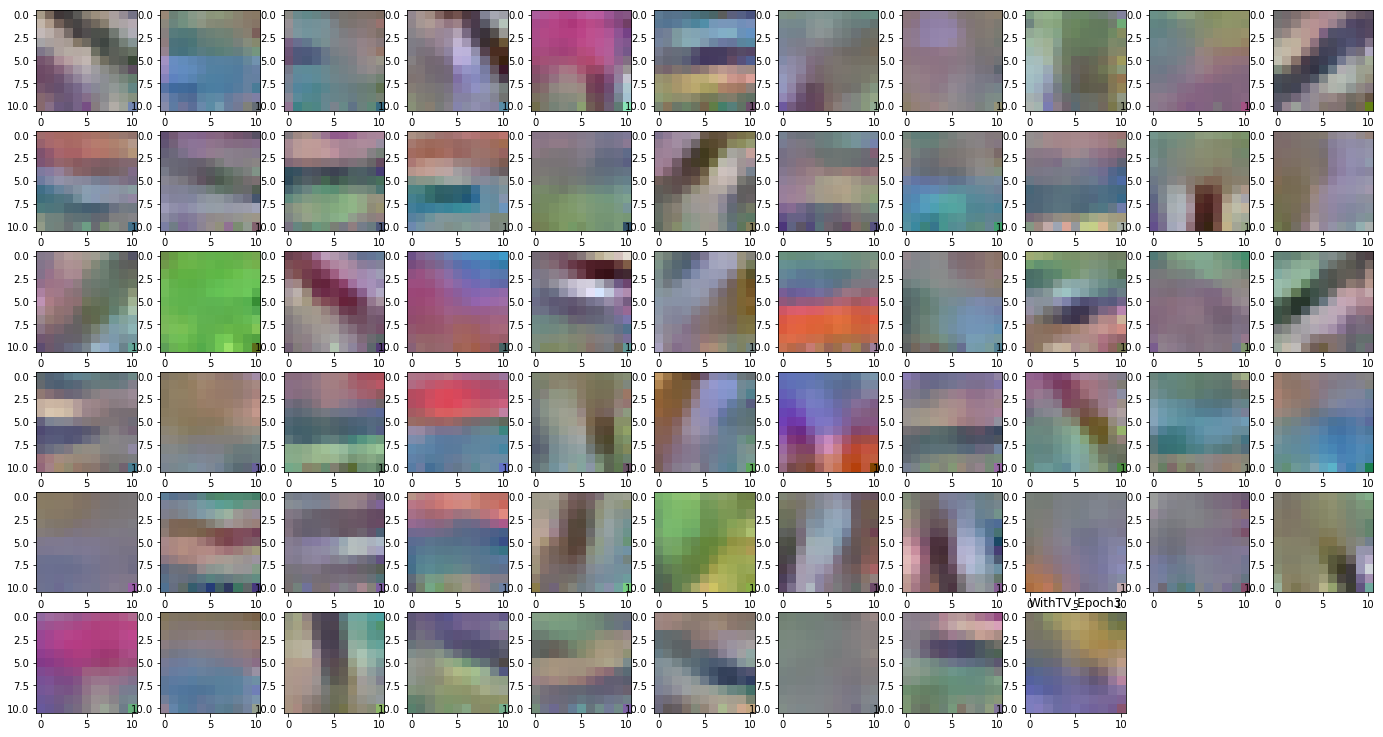

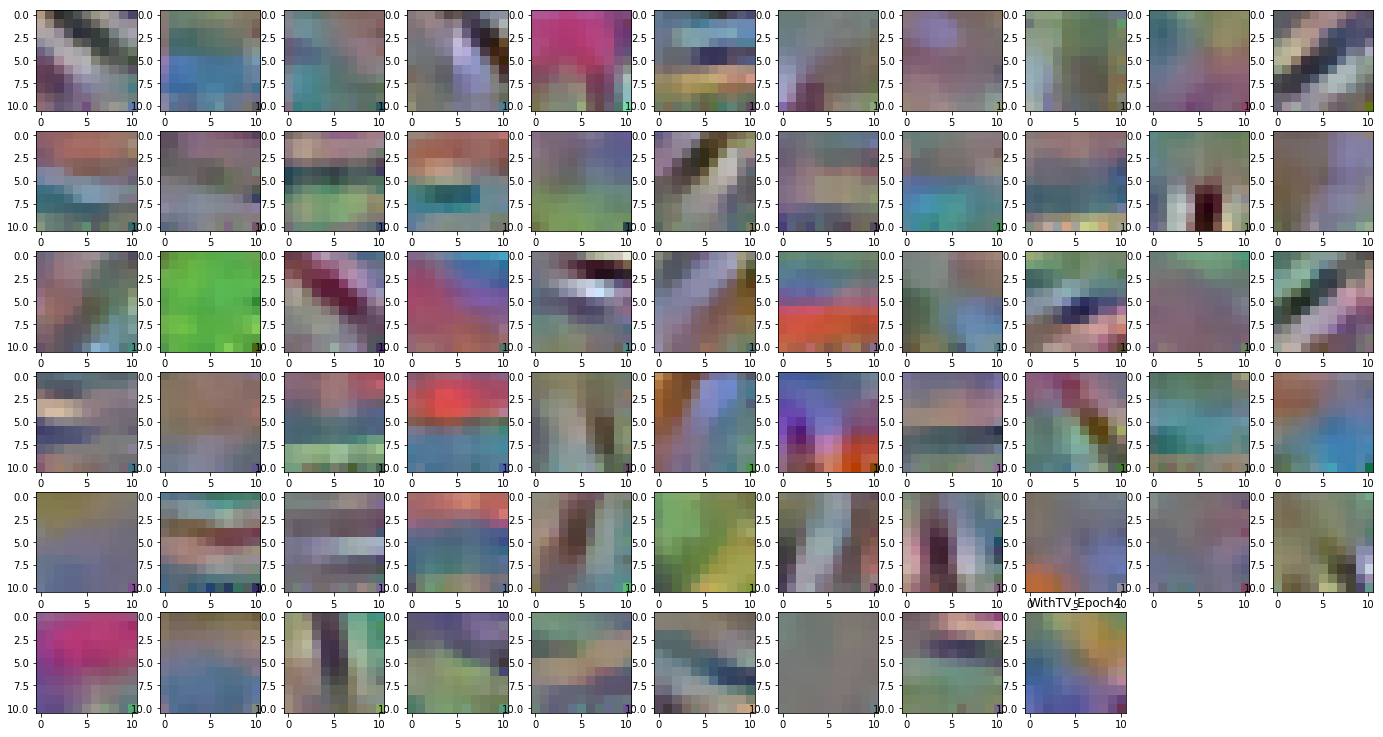

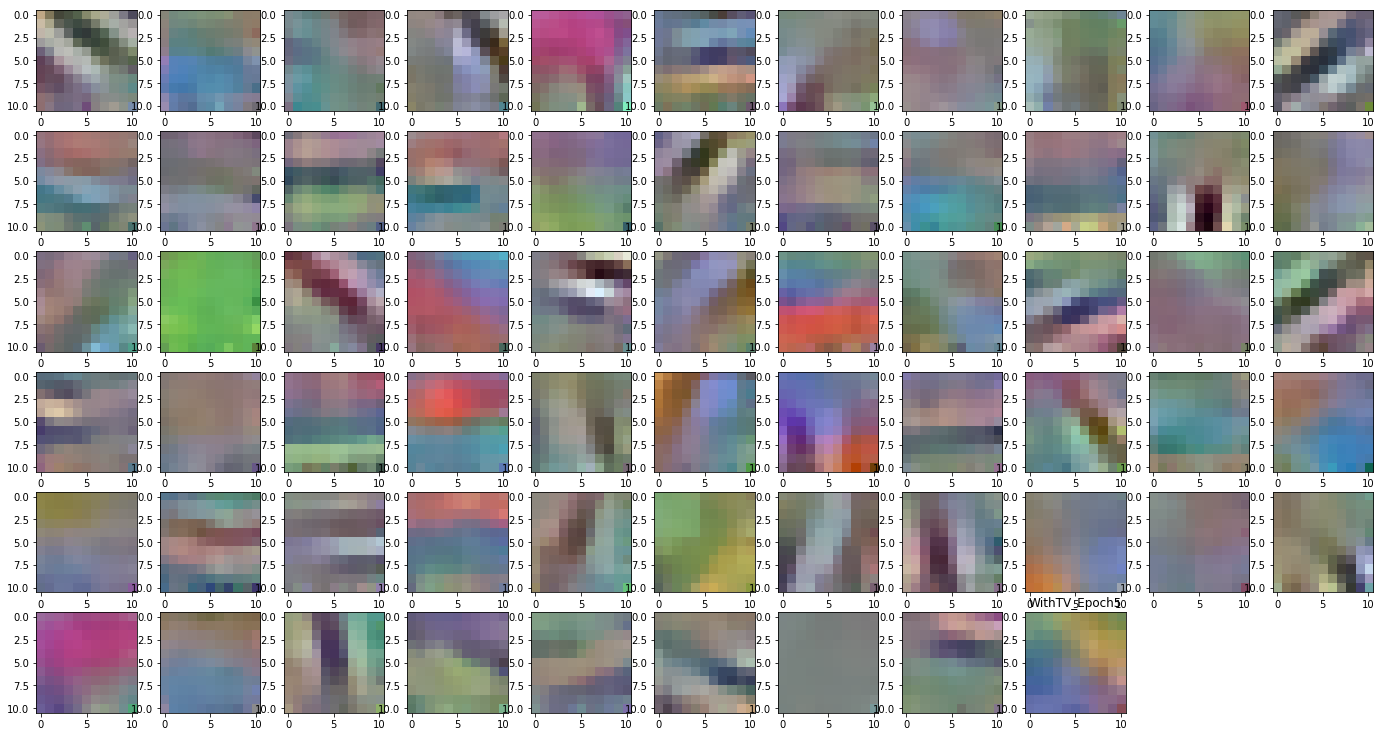

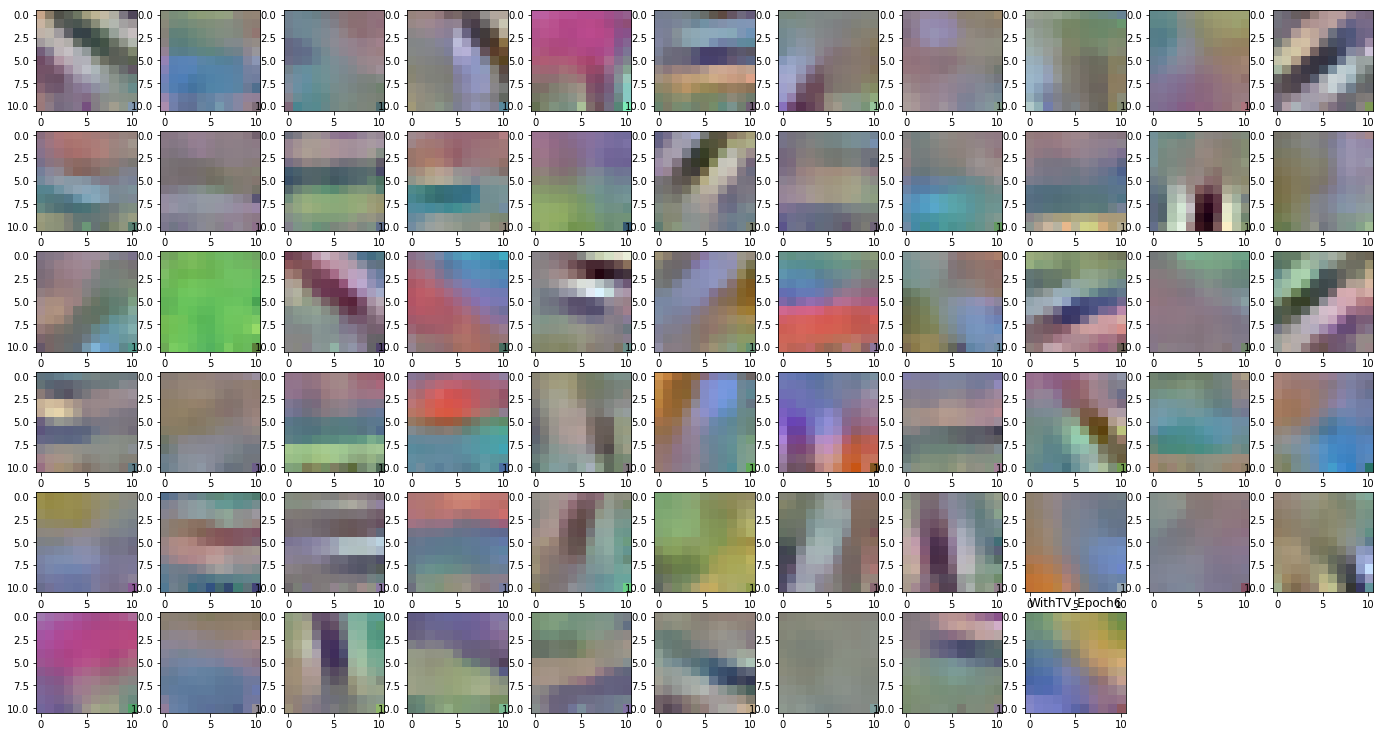

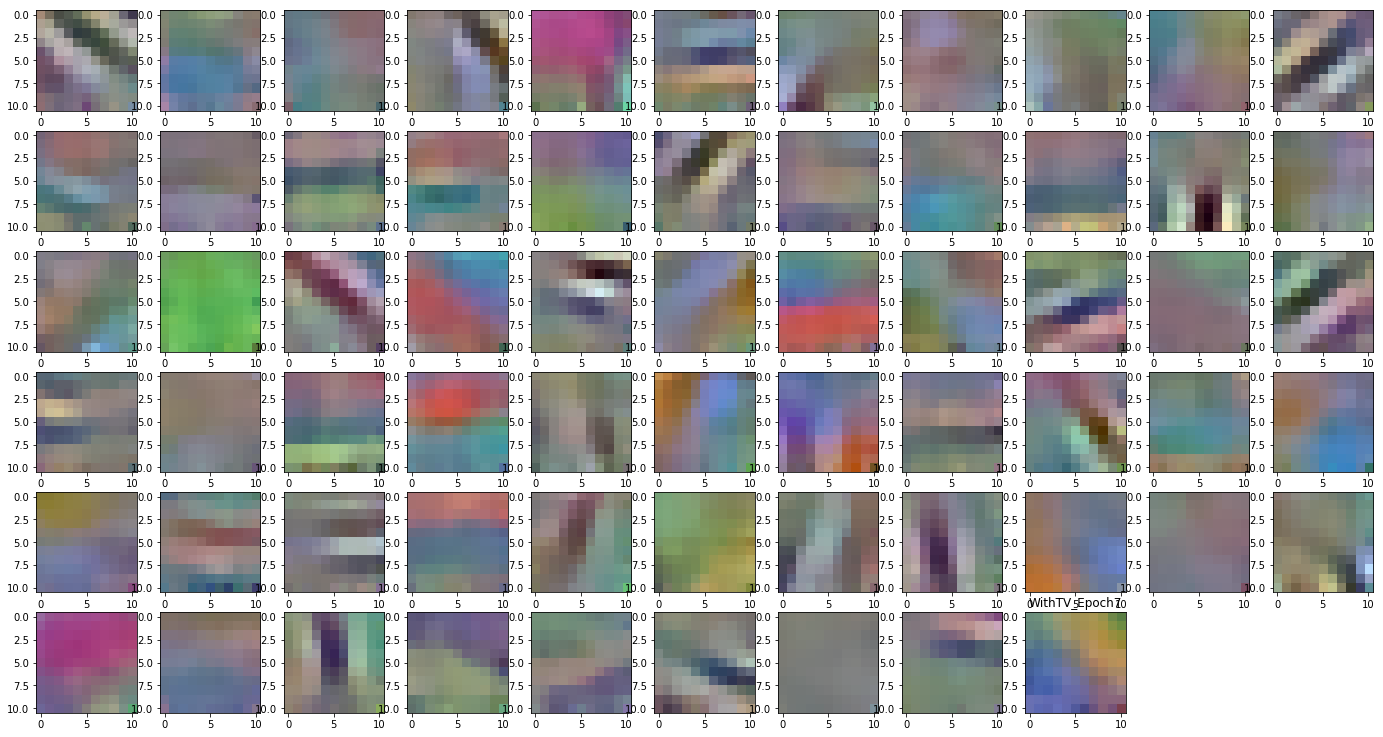

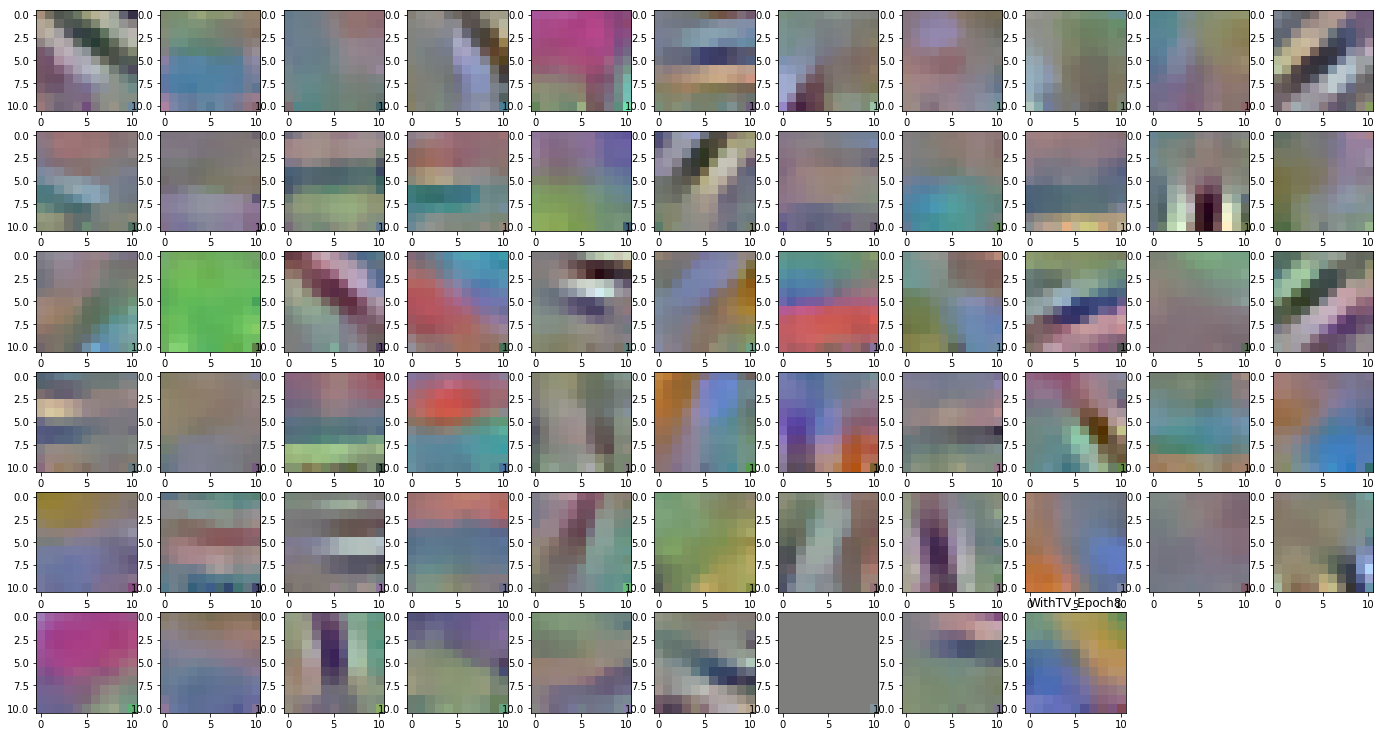

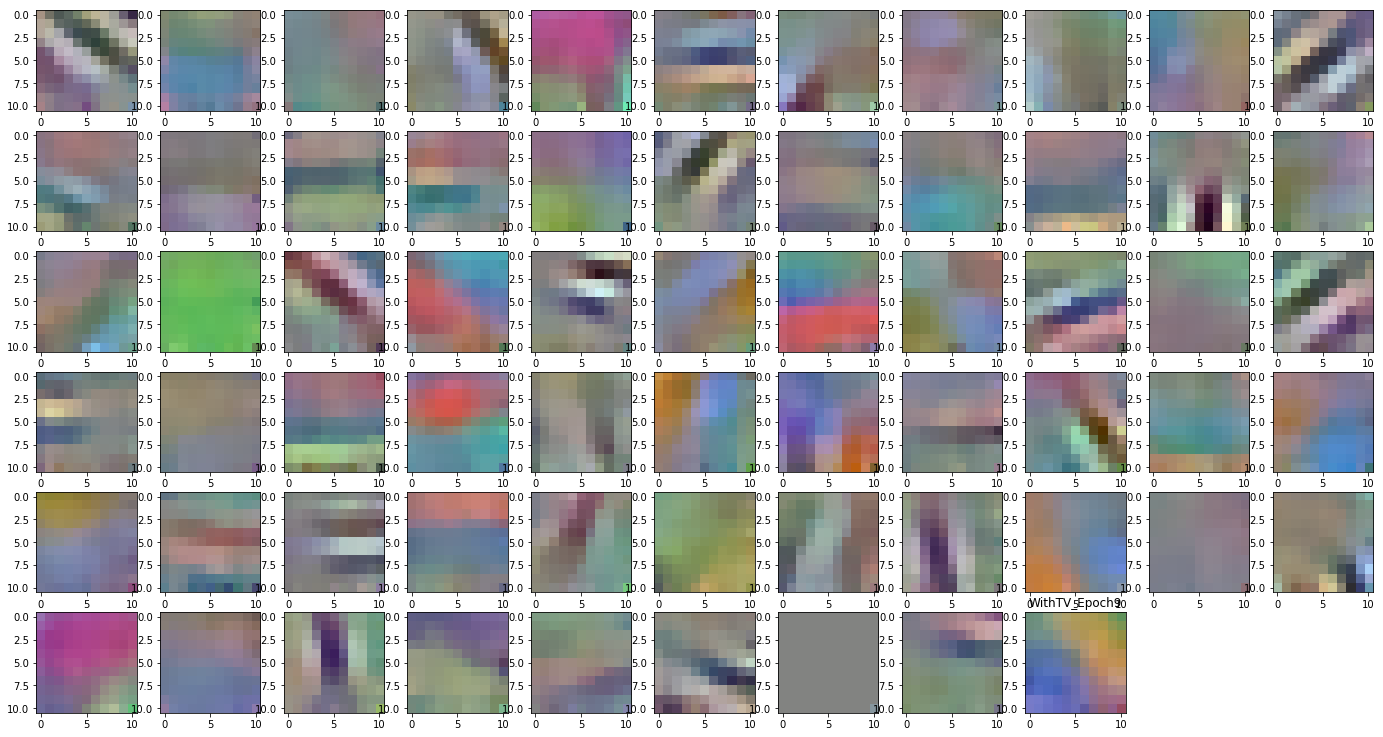

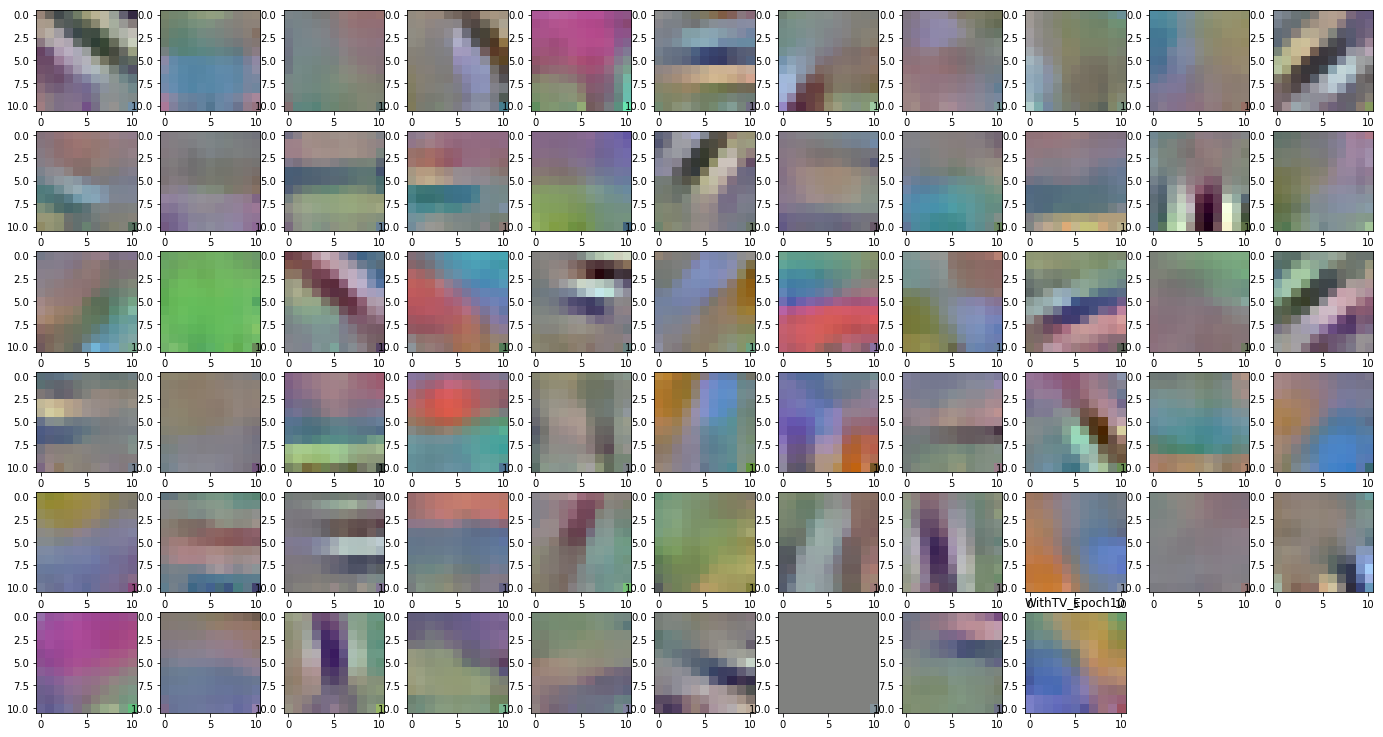

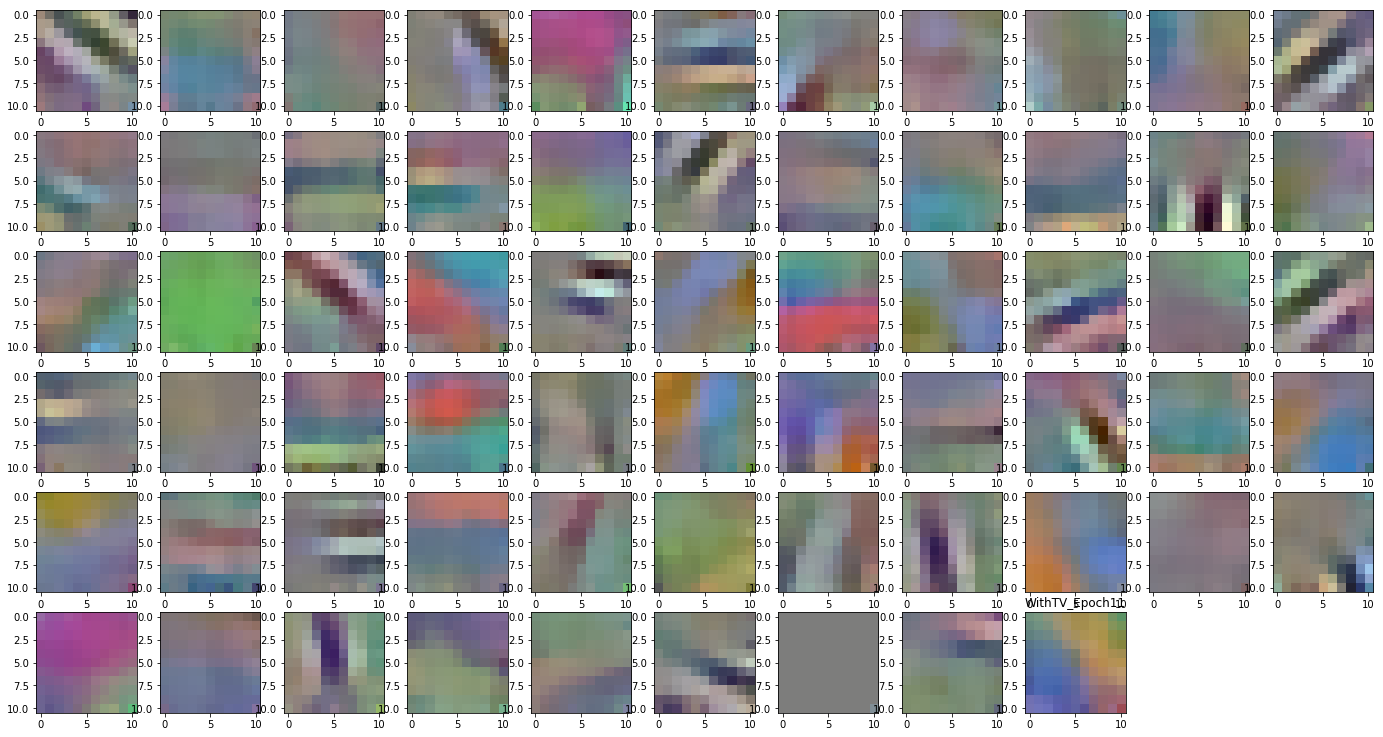

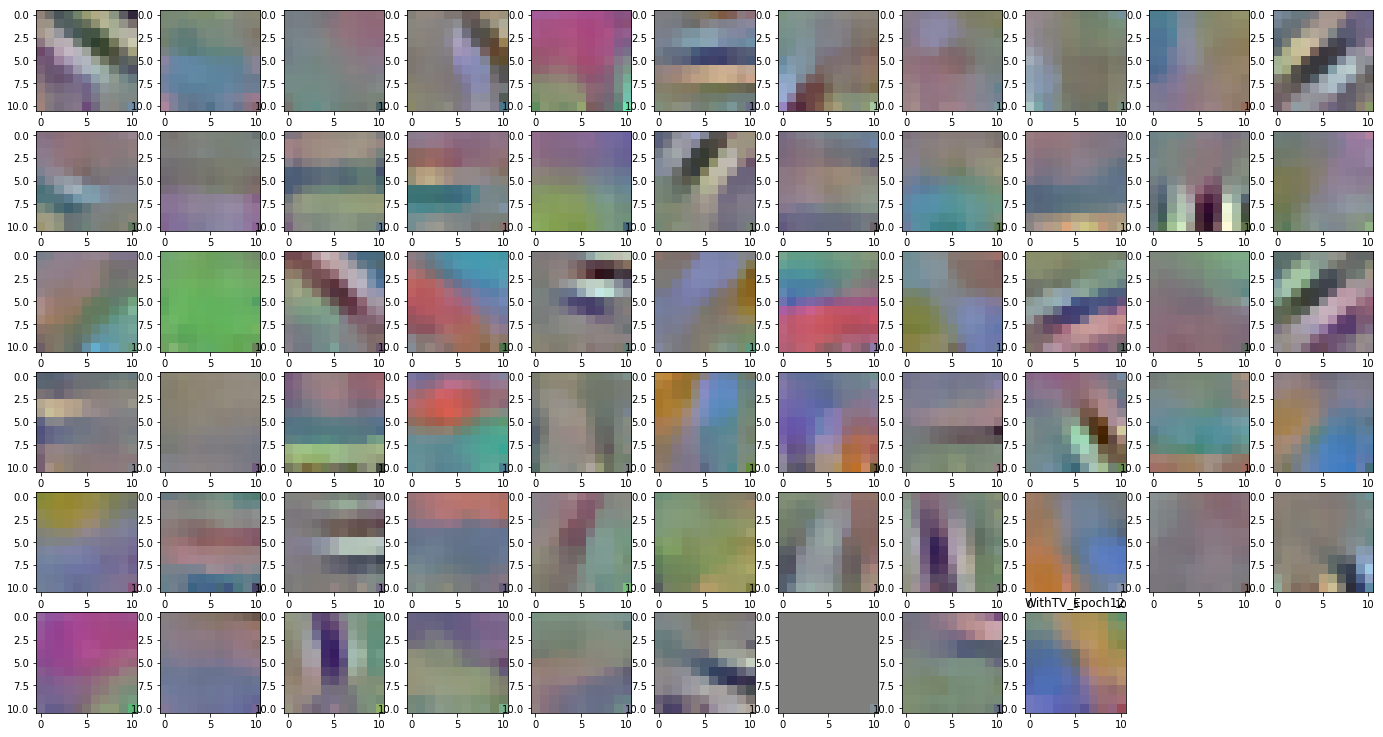

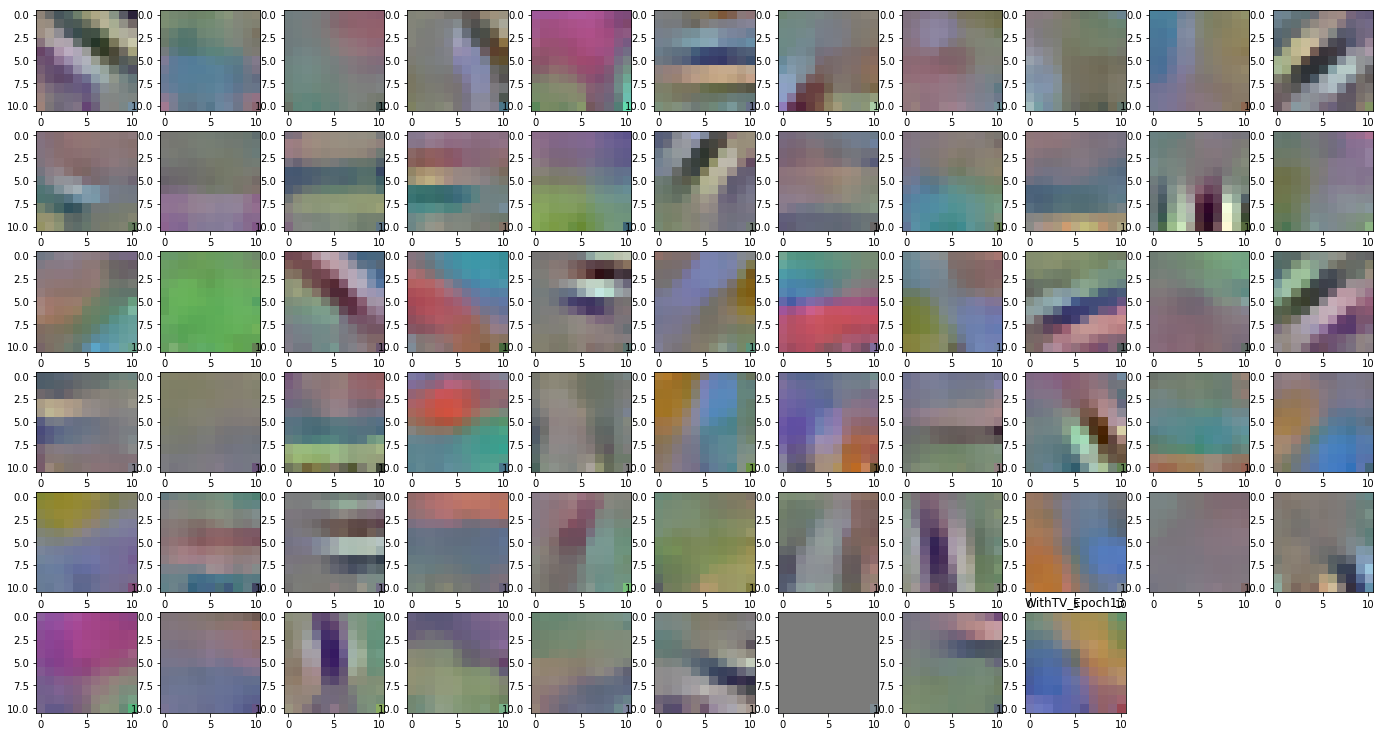

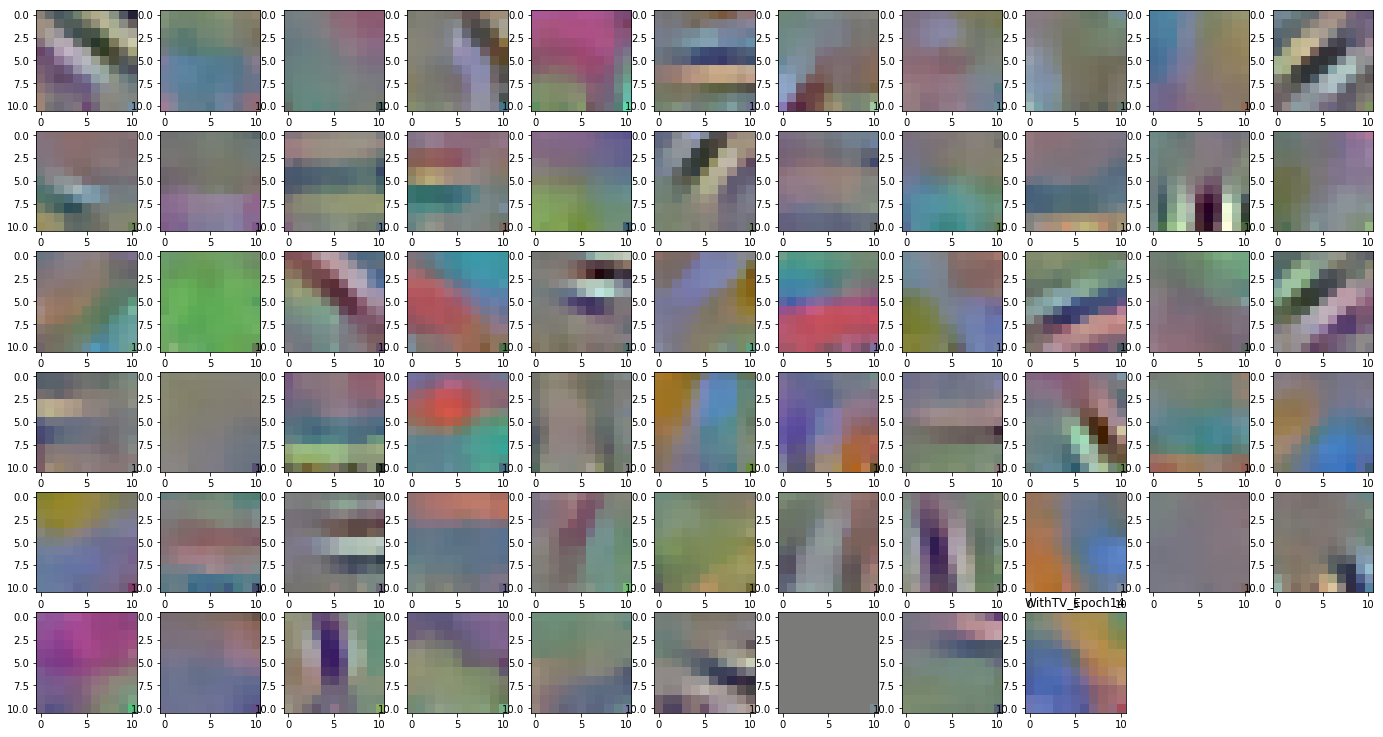

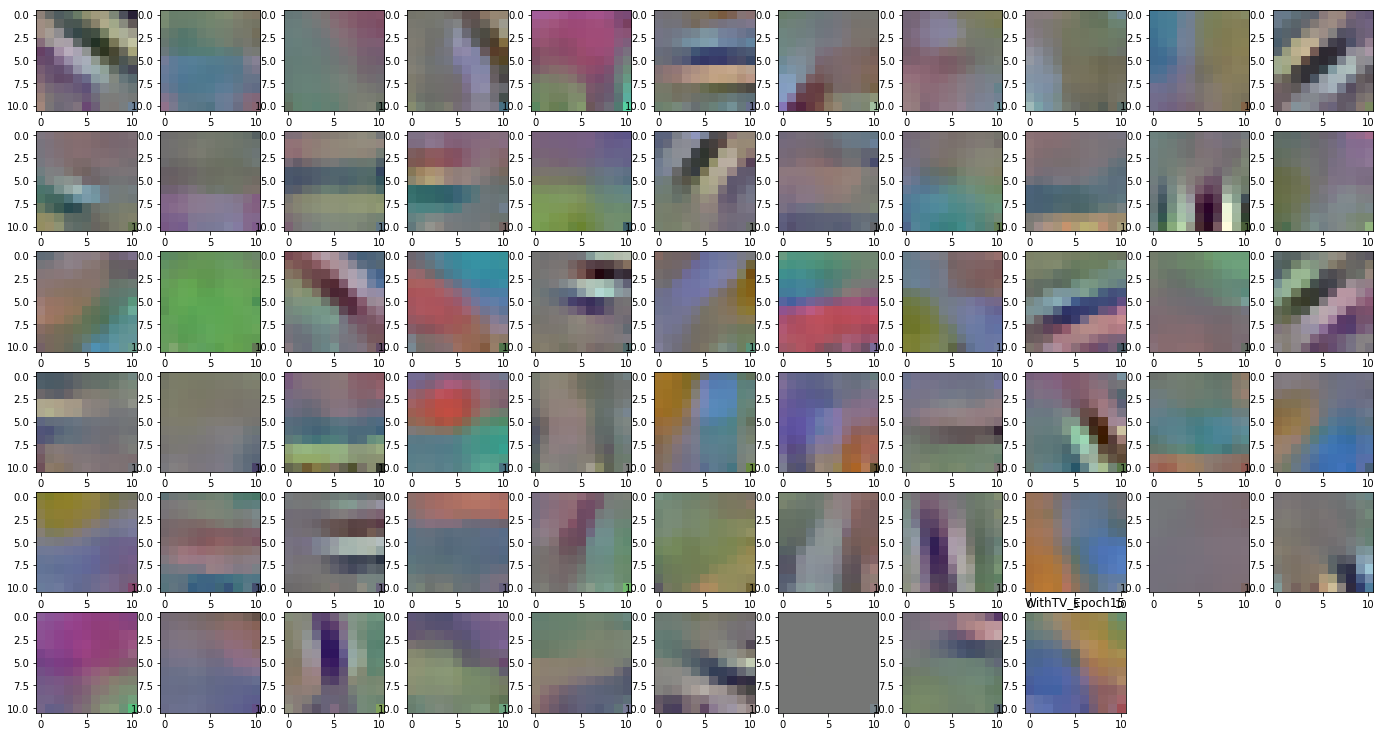

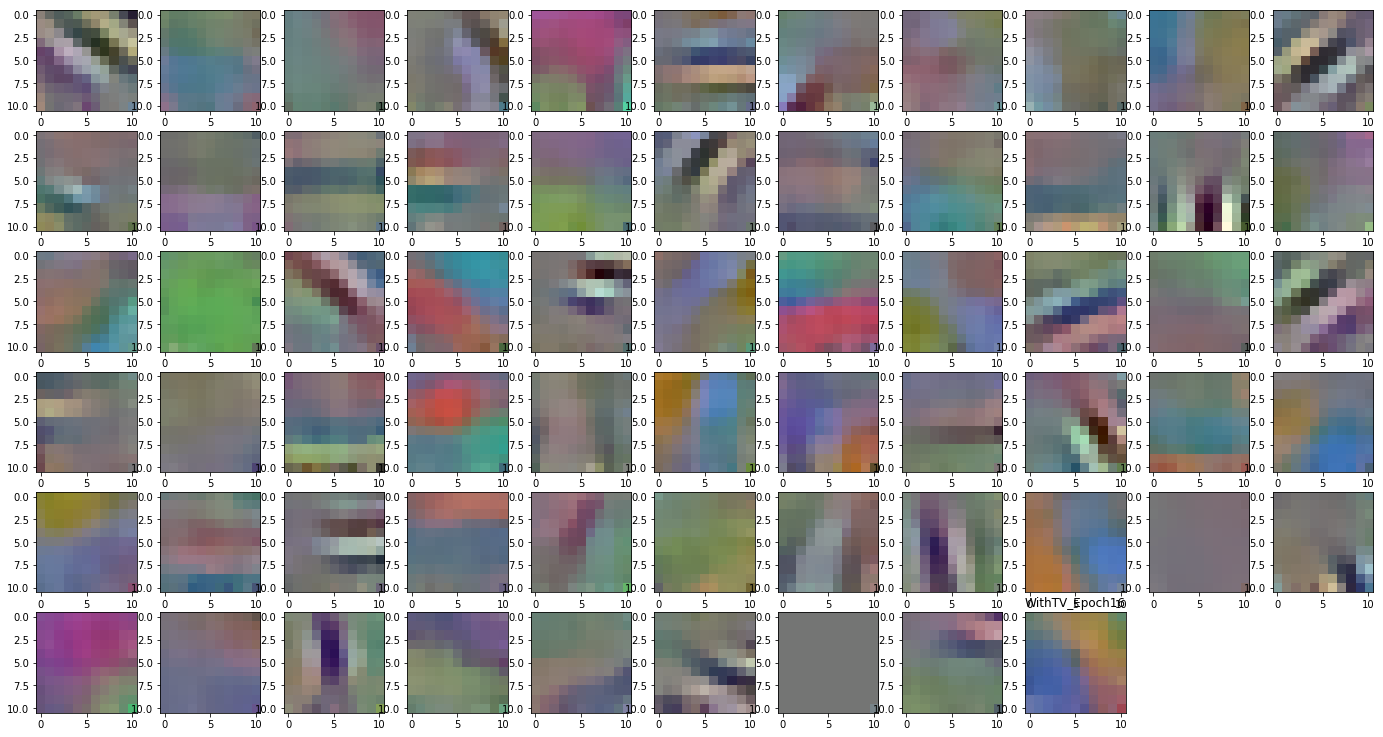

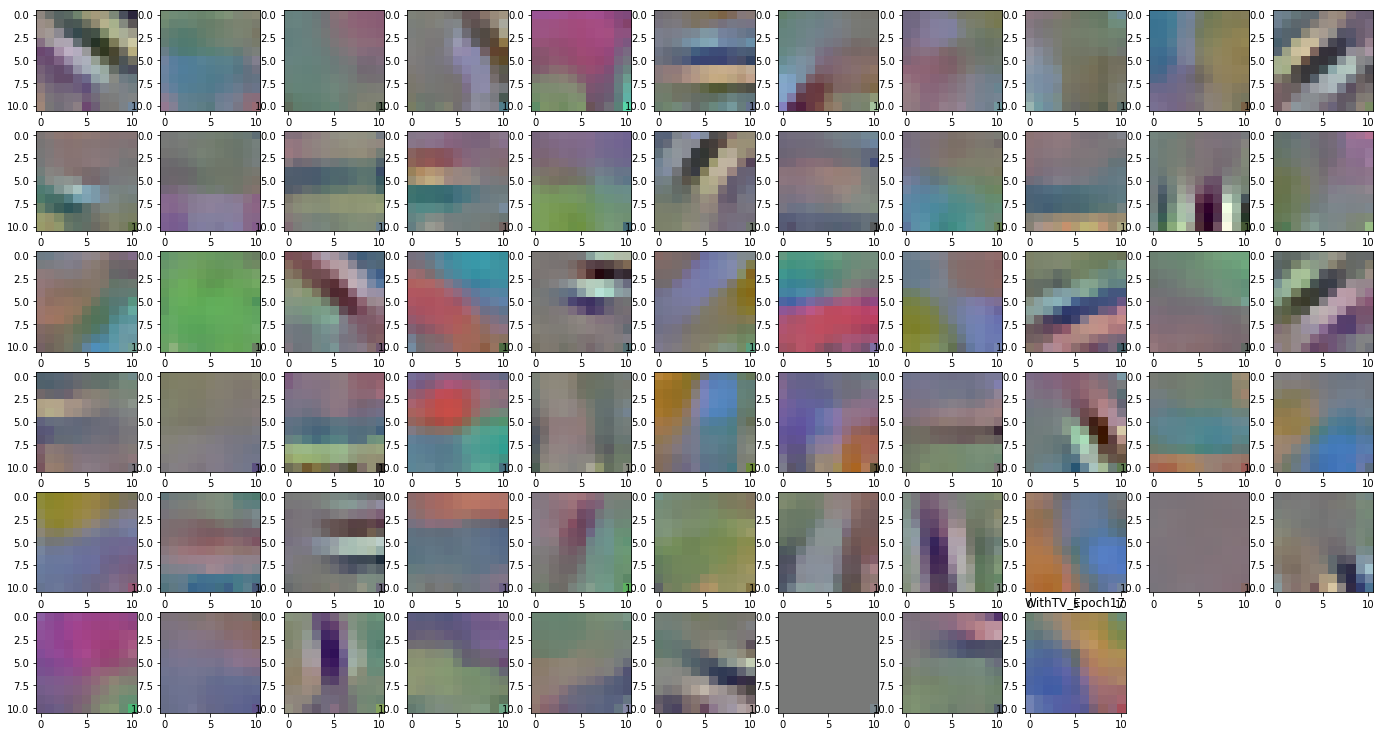

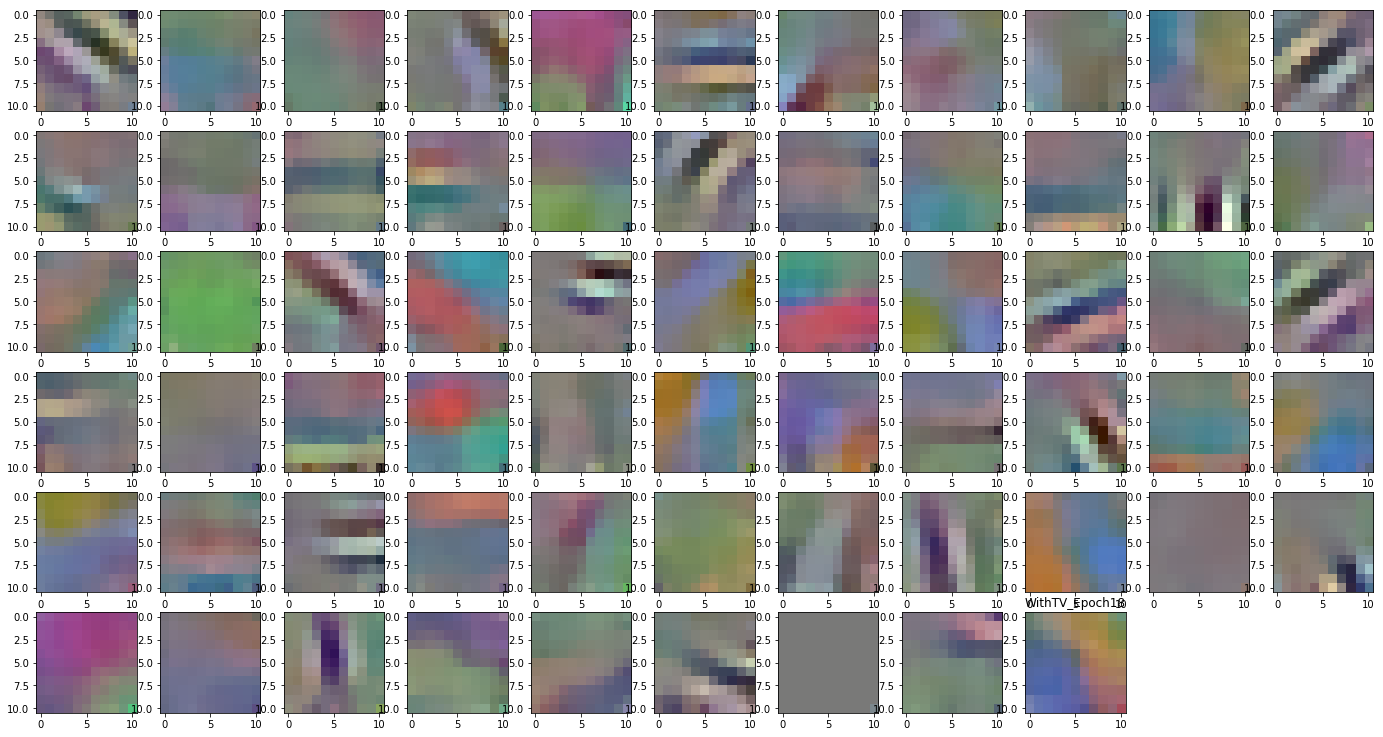

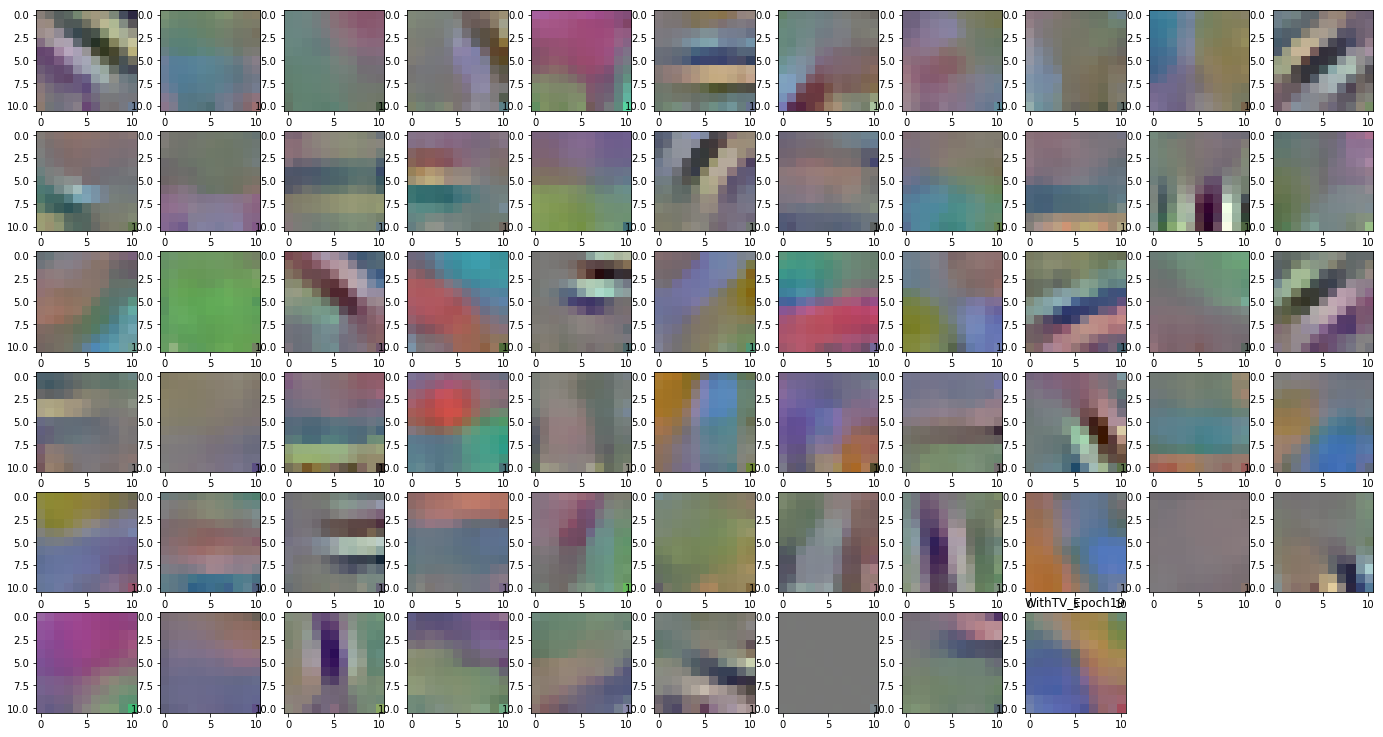

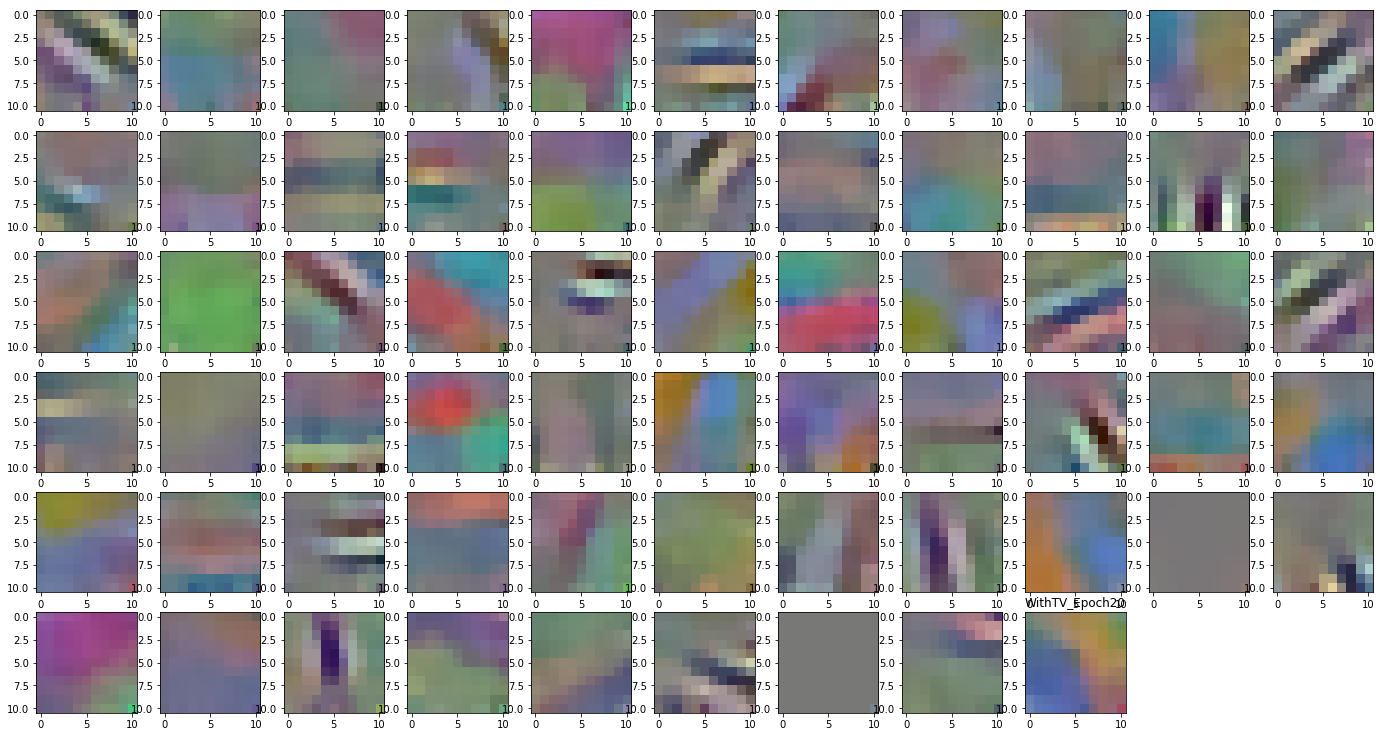

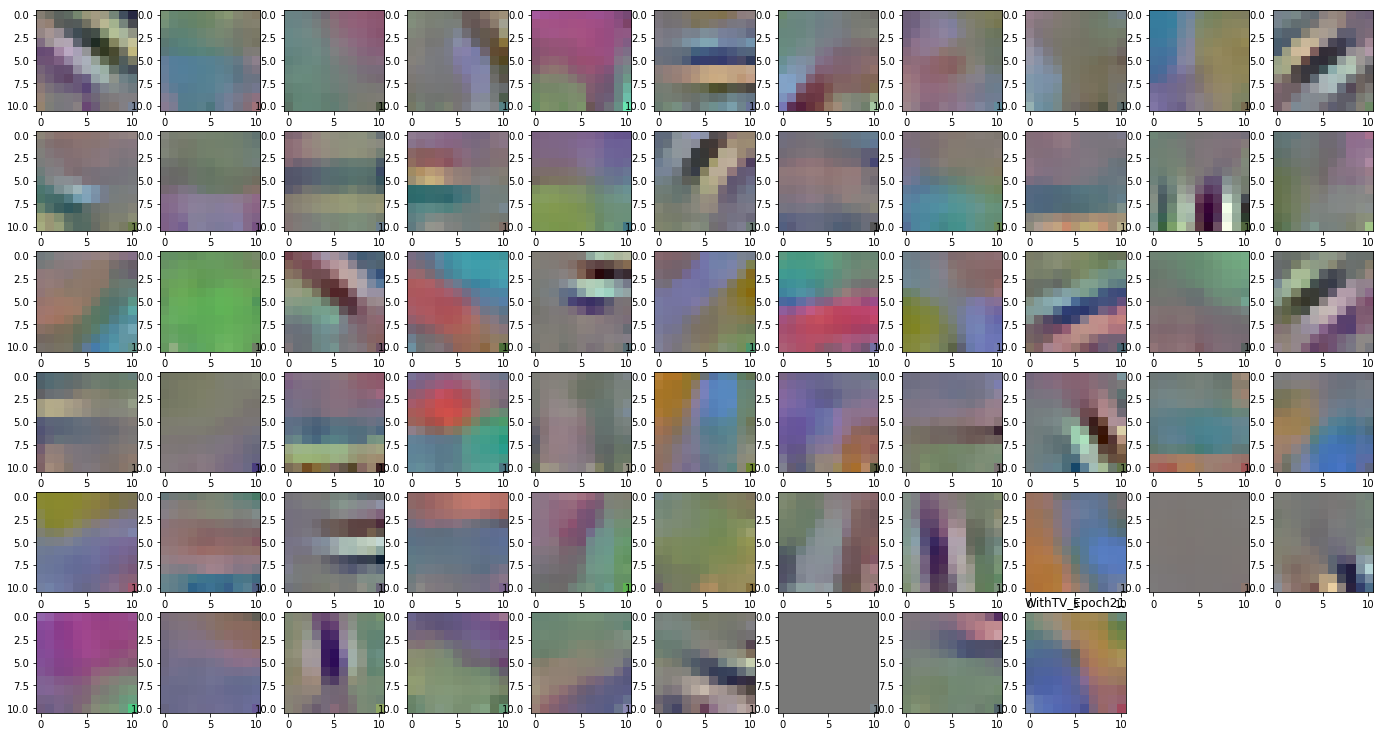

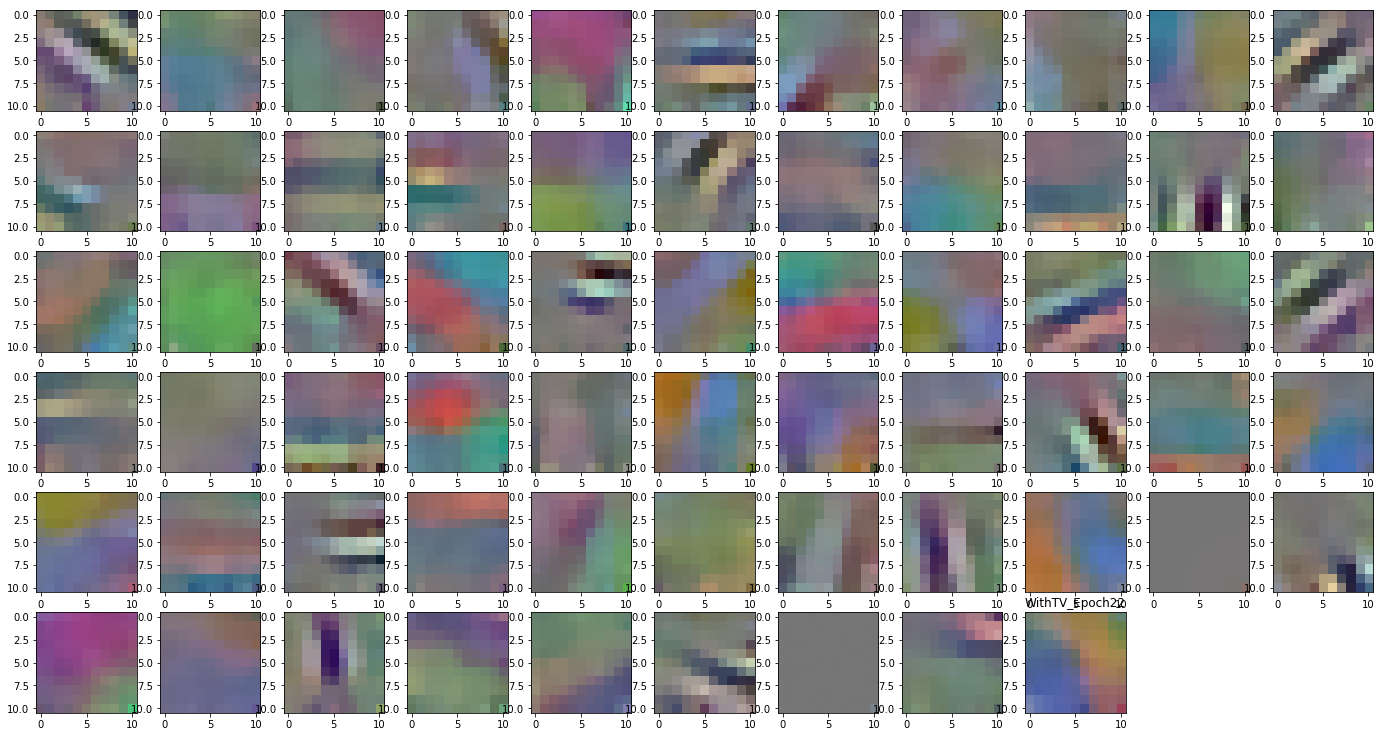

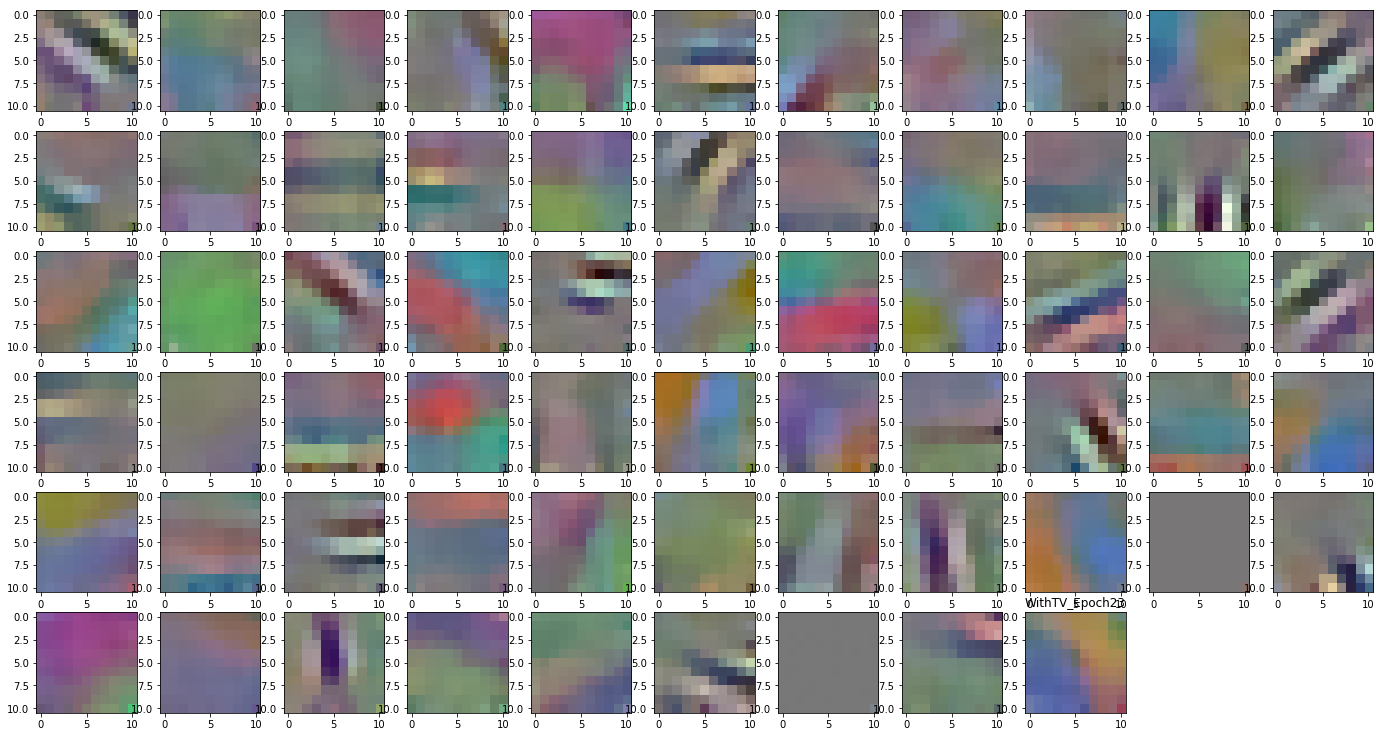

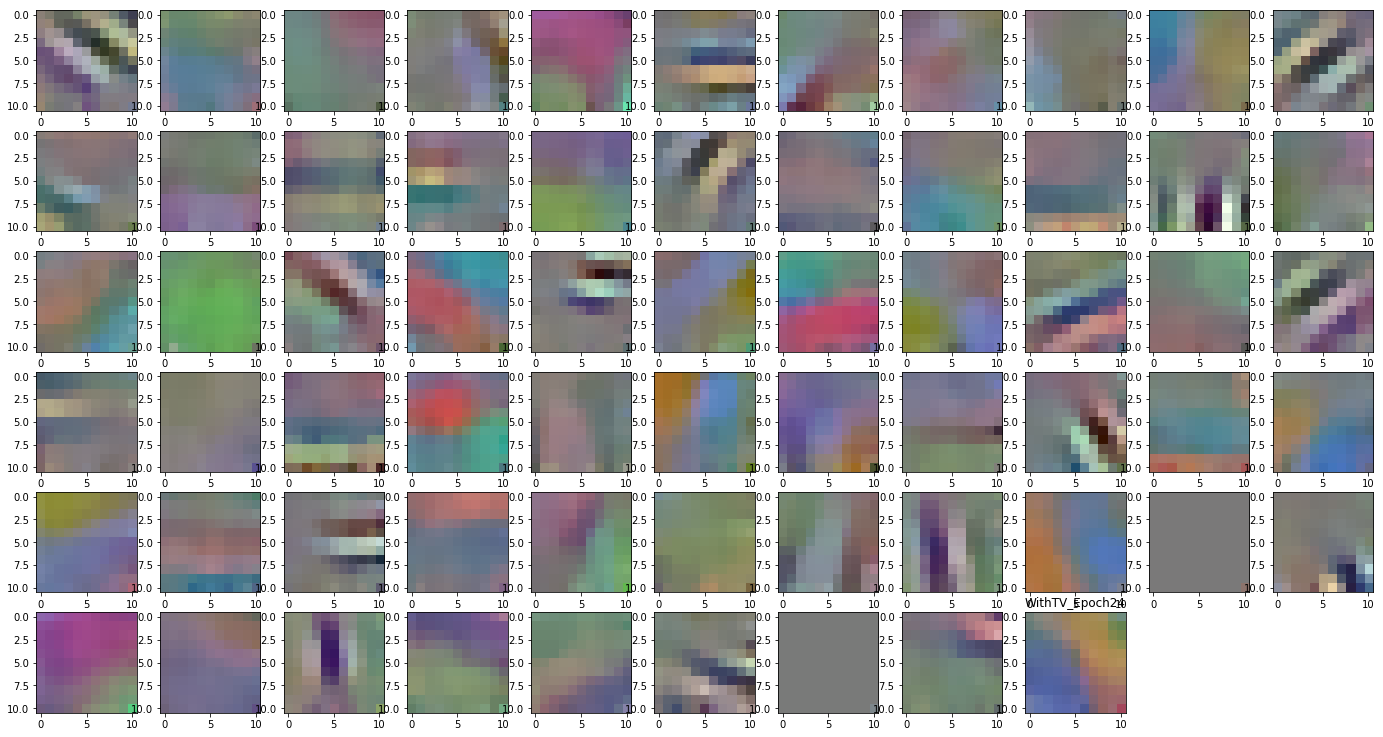

In [21]:
without_tv, with_tv = compare(3)

## Visualizations

In [41]:
import matplotlib.pyplot as plt

### Trial Results

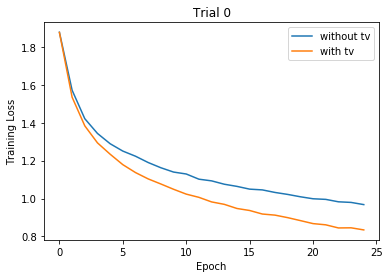

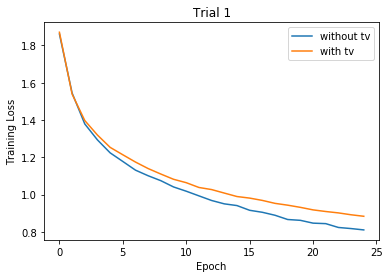

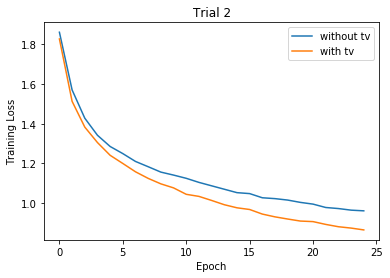

In [57]:
for i in range(3):
    plt.plot(range(25),without_tv[i]['losses'], label="without tv")
    plt.plot(range(25),with_tv[i]['losses'], label = "with tv")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Trial " + str(i))
    plt.show()

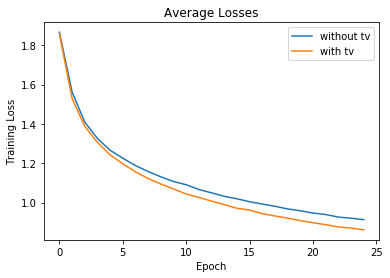

In [58]:
plt.plot(range(25),[(a+b+c)/3 for a,b,c in zip(*[without_tv[i]['losses'] for i in range(3)])], label="without tv")
plt.plot(range(25),[(a+b+c)/3 for a,b,c in zip(*[with_tv[i]['losses'] for i in range(3)])], label = "with tv")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Average Losses")
plt.show()

### Validation Losses

In [ ]:
for i in range(3):
    plt.plot(range(25),without_tv[i]['val_losses'], label="without tv")
    plt.plot(range(25),with_tv[i]['val_losses'], label = "with tv")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title("Trial " + str(i))
    plt.show()

### Experiment 2: All Layers